# Predicting Credit Card Default Risk: A Machine Learning Approach with Engineered Payment History Features
---
by [Olabanji Olaniyan](olaniyan4@coventry.ac.uk)

The specific objective of this coursework is to assist financial companies such as banks and credit card companies in modeling the risk associated of credit card default associated with a customer. The goal of this risk modeling is to present a data backed approach for to minimise losses by accurately predicting credit card defaulters and maximise profits by accurately predicting credit card non defaulters.

In this coursework, we shall utilise five supervised machine learning methods to predict whether a customer defaults on his/her credit card loan or not. 

1. Decision Tree
2. K-Nearest Neighbours
3. XGBoost
4. Support Vector Machines
5. Logisitic Regression


## Import Libraries

In [1]:
# import regular data science /ml libraries
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# used in the definition of some parameter distributions
from scipy.stats import randint, uniform, loguniform 

# to track time of training and tunining
import time 

# used to save the random search object which contained the finetuned model
import joblib


# preprocessing and metrics libraries
# Used to automate the oversampling in the training of classifiers to avoid data leakage
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score,precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split,cross_val_predict, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Import Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Setting random state for reproducibility and Template for Visualisations
random_state= 70 

plt.style.use("seaborn-v0_8-whitegrid")
#plt.rcParams["text.usetex"] = False
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 11
})
sns.set_palette("colorblind")

## 1. Load The Dataset

In [2]:
# fetch dataset from uci
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

**Updated Dataset Description**

|Column Name |Description of Column|Units of Measurement|
|------------|---------------------|--------------------|
| X1         | Amount of the given credit: This includes the total consumer credit for an individual and their family's supplementart credit| New Taiwan Dollar (NT)|
| X2         |Gender               |The gender of individual|1 = male; 2 = female
| X3         | The highest attained education of the indicidual|1 = graduate school; 2 = university; 3 = high school; 4,5,6,0 = others.
| X4          | Marital status|0 = others, 1 = married; 2 = single; 3 = others|
| X5          | Age| The age of the individual in yeara|
| X6          | Repayment status in September 2005 | Repayment delay scale                      
| X7          | Repayment status in August 2005    | Repayment delay scale                      
| X8          | Repayment status in July 2005      | Repayment delay scale                      
| X9          | Repayment status in June 2005      | Repayment delay scale                      
| X10         | Repayment status in May 2005       | Repayment delay scale                      
| X11         | Repayment status in April 2005     | Repayment delay scale                      
| X12         | Amount of bill statement in September 2005   | New Taiwan Dollar (NT)    
| X13         | Amount of bill statement in August 2005      | New Taiwan Dollar (NT)    
| X14         | Amount of bill statement in July 2005        | New Taiwan Dollar (NT)    
| X15         | Amount of bill statement in June 2005        | New Taiwan Dollar (NT)    
| X16         | Amount of bill statement in May 2005          | New Taiwan Dollar (NT)    
| X17         | Amount of bill statement in April 2005        | New Taiwan Dollar (NT)     
| X18         | Amount of previous payment in September 2005 | New Taiwan Dollar (NT)    
| X19         | Amount of previous payment in August 2005    | New Taiwan Dollar (NT)    
| X20         | Amount of previous payment in July 2005      | New Taiwan Dollar (NT)    
| X21         | Amount of previous payment in June 2005      | New Taiwan Dollar (NT)    
| X22         | Amount of previous payment in May 2005       | New Taiwan Dollar (NT)    
| X23         | Amount of previous payment in April 2005     | New Taiwan Dollar (NT)    
| Y           | (Target variable) default payment next month  | - # 0 (non-default) or 1 (default)





**Measurement scale for repayment status:**

- `-2` = No consumption
- `-1` = Payment made duly (no delay)  
- `1` = Payment delayed for one month  
- `2` = Payment delayed for two months  
- `3` = Payment delayed for three months  
- `4` = Payment delayed for four months  
- `5` = Payment delayed for five months  
- `6` = Payment delayed for six months  
- `7` = Payment delayed for seven months  
- `8` = Payment delayed for eight months  
- `9` = Payment delayed for nine months or more  



In [3]:
# Renaming of columns to intuitive names
names = {
    'X1': 'credit_amount',
    'X2':'gender',
    'X3': 'education',
    'X4':'marital_status',
    'X5':'age',
    'X6': 'sept_delay',
    'X7':'august_delay',
    'X8':'july_delay',
    'X9':'june_delay',
    'X10':'may_delay',
    'X11':'april_delay',
    'X12': 'sept_bill' ,
    'X13': 'august_bill',
    'X14': 'july_bill'   ,
    'X15': 'june_bill',
    'X16':'may_bill'   ,
    'X17':'april_bill' ,
    'X18':'sept_payment',
    'X19':'august_payment',
    'X20':'july_payment'   ,
    'X21':'june_payment'   ,
    'X22':'may_payment'     ,
    'X23':'april_payment'}

X = X.copy().rename(columns= names)
X.head()

credit_amount  gender  education  marital_status  age  sept_delay  \
0          20000       2          2               1   24           2   
1         120000       2          2               2   26          -1   
2          90000       2          2               2   34           0   
3          50000       2          2               1   37           0   
4          50000       1          2               1   57          -1   

   august_delay  july_delay  june_delay  may_delay  ...  july_bill  june_bill  \
0             2          -1          -1         -2  ...        689          0   
1             2           0           0          0  ...       2682       3272   
2             0           0           0          0  ...      13559      14331   
3             0           0           0          0  ...      49291      28314   
4             0          -1           0          0  ...      35835      20940   

   may_bill  april_bill  sept_payment  august_payment  july_payment  \
0         0           0             0             689             0   
1      3455        3261             0            1000          1000   
2     14948       15549          1518            1500          1000   
3     28959       29547          2000            2019          1200   
4     19146       19131          2000           36681         10000   

   june_payment  may_payment  april_payment  
0             0            0              0  
1          1000            0           2000  
2          1000         1000           5000  
3          1100         1069           1000  
4          9000          689            679  

[5 rows x 23 columns]

## **2. Exploratory Data Analysis**
---

In [4]:
df = pd.concat((X,y), axis= 1)

# Create copy for Exploratory Data Analysis
df_eda = df.copy()
df_eda.head()

credit_amount  gender  education  marital_status  age  sept_delay  \
0          20000       2          2               1   24           2   
1         120000       2          2               2   26          -1   
2          90000       2          2               2   34           0   
3          50000       2          2               1   37           0   
4          50000       1          2               1   57          -1   

   august_delay  july_delay  june_delay  may_delay  ...  june_bill  may_bill  \
0             2          -1          -1         -2  ...          0         0   
1             2           0           0          0  ...       3272      3455   
2             0           0           0          0  ...      14331     14948   
3             0           0           0          0  ...      28314     28959   
4             0          -1           0          0  ...      20940     19146   

   april_bill  sept_payment  august_payment  july_payment  june_payment  \
0           0             0             689             0             0   
1        3261             0            1000          1000          1000   
2       15549          1518            1500          1000          1000   
3       29547          2000            2019          1200          1100   
4       19131          2000           36681         10000          9000   

   may_payment  april_payment  Y  
0            0              0  1  
1            0           2000  1  
2         1000           5000  0  
3         1069           1000  0  
4          689            679  0  

[5 rows x 24 columns]

In [5]:
# Check for null and duplicate entries
print("===== Null entries =====")
print(df_eda.isna().sum())
print()
print("===== Duplicate entries =====")
print(df_eda.duplicated().sum())

===== Null entries =====
credit_amount     0
gender            0
education         0
marital_status    0
age               0
sept_delay        0
august_delay      0
july_delay        0
june_delay        0
may_delay         0
april_delay       0
sept_bill         0
august_bill       0
july_bill         0
june_bill         0
may_bill          0
april_bill        0
sept_payment      0
august_payment    0
july_payment      0
june_payment      0
may_payment       0
april_payment     0
Y                 0
dtype: int64

===== Duplicate entries =====
35


### 2.1 Exploration of Continuous and Categorical Data
---

In [6]:
# Continuous Data
continuous_data = [
    'credit_amount',
    'sept_bill',
    'august_bill',
    'july_bill',
    'june_bill',
    'may_bill',
    'april_bill',
    'sept_payment',
    'august_payment',
    'july_payment',
    'june_payment',
    'may_payment',
    'april_payment'
    ]

# Categorical Data
# I used set operation to remove the continuous columns in the list of all the columns then converted it back to a list.
categorical_data = list(set(df.columns.to_list()) - set(continuous_data))

In [7]:
# check categorical dat and continuous data
print(f'{"="*40} Five rows for categorical data {"="*40}')
print(df_eda[categorical_data].head())
print()
print(f'{"="*40} Five rows for continuous data {"="*40}')
print(df[continuous_data].head())

======================================== Five rows for categorical data ========================================
   age  gender  education  april_delay  marital_status  august_delay  \
0   24       2          2           -2               1             2   
1   26       2          2            2               2             2   
2   34       2          2            0               2             0   
3   37       2          2            0               1             0   
4   57       1          2            0               1             0   

   june_delay  sept_delay  july_delay  Y  may_delay  
0          -1           2          -1  1         -2  
1           0          -1           0  1          0  
2           0           0           0  0          0  
3           0           0           0  0          0  
4           0          -1          -1  0          0  

======================================== Five rows for continuous data ========================================
   credit_amount 

In [8]:
# Creation of categorical map for categorical data for easy understanding of the dataset
gender_map = {
    1: 'male',
    2: 'female'
}

education_map = {
    0: 'others',
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}

marital_map = {
    0: 'others',
    1: 'married',
    2: 'single',
    3: 'divorce'
               }

target_map = {
    0: 'non-default',
    1: 'default'
    }

# Payment Delay Map
delay_map = {
  -2: 'no usage',
  -1: 'paid full',
   0: 'revolving',
   1: '1m delay',
   2: '2m delay',
   3: '3m delay',
   4: '4m delay',
   5: '5m delay',
   6: '6m delay',
   7: '7m delay',
   8: '8m delay',
   9: '9m+ delay'
   }

# function to group ages into decades
def convert_age(age):
    """
    Converts age into decades for easy exploration.
    
    Parameters
    ----------
    age : int
        Age of consumer.


    Returns
    -------
    decade : str
        Age converted into relevant decade.
    
    """
    
    # divide age by 10 to determine the decade
    age = age//10
    decade = f'{age*10}s'
    return decade

In [9]:
print("===== Five rows for categorical data (before mapping) =====")
print(df_eda[categorical_data].head())

# application of the categorical map to all the columns
df_eda['gender'] = df_eda['gender'].map(gender_map )
df_eda['education'] = df_eda['education'].map(education_map)
df_eda['marital_status'] = df_eda['marital_status'].map(marital_map)
df_eda['Y'] = df_eda['Y'].map(target_map)
df_eda['age'] = df_eda['age'].map(convert_age)

# Select delay columns
delay = [column_name for column_name in categorical_data if 'delay' in column_name.lower()]
df_eda[delay] = df_eda[delay].apply(lambda column: column.map(delay_map))

# let us check the categorical data now
print("===== Five rows for categorical data (after mapping) =====")
print(df_eda[categorical_data].head())

===== Five rows for categorical data (before mapping) =====
   age  gender  education  april_delay  marital_status  august_delay  \
0   24       2          2           -2               1             2   
1   26       2          2            2               2             2   
2   34       2          2            0               2             0   
3   37       2          2            0               1             0   
4   57       1          2            0               1             0   

   june_delay  sept_delay  july_delay  Y  may_delay  
0          -1           2          -1  1         -2  
1           0          -1           0  1          0  
2           0           0           0  0          0  
3           0           0           0  0          0  
4           0          -1          -1  0          0  
===== Five rows for categorical data (after mapping) =====
   age  gender   education april_delay marital_status august_delay june_delay  \
0  20s  female  university    no usage     

In [10]:
bill = [column_name for column_name in continuous_data if 'bill' in column_name]
payment = [column_name for column_name in continuous_data if 'payment' in column_name]

# Create total bill and payment for each consumer
df_eda["total_bill"] = df_eda[bill].sum(axis=1) 
df_eda['total_payment'] = df_eda[payment].sum(axis=1)

df_eda.head()

credit_amount  gender   education marital_status  age sept_delay  \
0          20000  female  university        married  20s   2m delay   
1         120000  female  university         single  20s  paid full   
2          90000  female  university         single  30s  revolving   
3          50000  female  university        married  30s  revolving   
4          50000    male  university        married  50s  paid full   

  august_delay july_delay june_delay  may_delay  ... april_bill  sept_payment  \
0     2m delay  paid full  paid full   no usage  ...          0             0   
1     2m delay  revolving  revolving  revolving  ...       3261             0   
2    revolving  revolving  revolving  revolving  ...      15549          1518   
3    revolving  revolving  revolving  revolving  ...      29547          2000   
4    revolving  paid full  revolving  revolving  ...      19131          2000   

   august_payment  july_payment  june_payment  may_payment  april_payment  \
0             689             0             0            0              0   
1            1000          1000          1000            0           2000   
2            1500          1000          1000         1000           5000   
3            2019          1200          1100         1069           1000   
4           36681         10000          9000          689            679   

             Y  total_bill  total_payment  
0      default        7704            689  
1      default       17077           5000  
2  non-default      101653          11018  
3  non-default      231334           8388  
4  non-default      109339          59049  

[5 rows x 26 columns]

In [11]:
print(df_eda.describe())

        credit_amount      sept_bill    august_bill     july_bill  \
count    30000.000000   30000.000000   30000.000000  3.000000e+04   
mean    167484.322667   51223.330900   49179.075167  4.701315e+04   
std     129747.661567   73635.860576   71173.768783  6.934939e+04   
min      10000.000000 -165580.000000  -69777.000000 -1.572640e+05   
25%      50000.000000    3558.750000    2984.750000  2.666250e+03   
50%     140000.000000   22381.500000   21200.000000  2.008850e+04   
75%     240000.000000   67091.000000   64006.250000  6.016475e+04   
max    1000000.000000  964511.000000  983931.000000  1.664089e+06   

           june_bill       may_bill     april_bill   sept_payment  \
count   30000.000000   30000.000000   30000.000000   30000.000000   
mean    43262.948967   40311.400967   38871.760400    5663.580500   
std     64332.856134   60797.155770   59554.107537   16563.280354   
min   -170000.000000  -81334.000000 -339603.000000       0.000000   
25%      2326.750000    1763.0000

#### 2.1.1  *Functions for EDA Plots*
---

In [12]:
# strictly for distribution of continuous variables by categorical
# BOXPLOT
def plot_boxplot(column, data=df_eda, title=None, hue=None, by=None, save=False):
    """
    Plots the distribution of a numerical feature using a boxplot, including
    median, quartiles, and outliers. Optionally, compares distributions across
    categories using a hue (e.g., distribution of credit_amount by age group).

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame containing the feature and optional hue column. Defaults to df_eda
    column : str
        The name of the numerical column to be plotted (continuous).
    title : str, optional
        The title of the boxplot. Default is None.
    hue : str, optional
        The categorical column to compare distributions across. Default is None.
    by : str, optional
        Categorical column which we eant to show our continuous variable by. Default is None.

    Returns
    -------
    None
        Displays the boxplot visualization.
    """

    try:
        plt.figure(figsize=(6,4))
        if hue is None:
            sns.boxplot(data= data, y = column, x = by)
        else:
            sns.boxplot(data= data, y = column, x = by, hue = hue)
            plt.legend(frameon='True')

            
        plt.ticklabel_format(style='plain', axis='y') # this disables the scientific notation
        plt.xticks(rotation =22.5)
        plt.title(title)
        plt.tight_layout()     
        if save:
            plt.savefig(fname = by + 'boxplot', 
                    dpi=300, 
                    bbox_inches='tight',    
                    pad_inches=0.1,         
                    facecolor='white')
        plt.show()

    except ValueError as ve:
        print(f"There is a Value Error")
        print(ve)



'''
Histograms are used to show data density and the overall shape of a distribution. They help us understand where values
cluster (high density), where they’re rare (low density)
'''

# HISTOGRAM
def plot_histogram(data = df_eda, column = None, title=None):
    """
    Shows the data distribution and shape of distribution through a histogram for feature/target variable.

    Parameters
    ----------
    data : pd.DataFrame
        This should be the dataframe containing both our target and feature. Defaults to df_eda.
    column : str
        Name of column to be plotted.
    title : str
        Title of the histogram.

    Returns
    -------
    None
        Returns the histogram.
    """

    if column in data:
        plt.figure(figsize= (7,4.5))
        sns.histplot(data= data, x = column, kde= True, label = column, color= 'blue')
        plt.ticklabel_format(style='plain', axis='x')
        plt.legend(frameon= True)
        plt.title(title)
        plt.grid(True, alpha = 0.3, axis= 'both')
        plt.tight_layout()
        plt.show()
    else:
        print(f"{column} not in data")

# BARCHART
def plot_barchart(column,  x_label,title=None, hue=None, data= df_eda, rotation=0, save = False):
    """
    Plots a bar chart showing value counts for a categorical column.

    This function creates a count plot (bar chart) to visualize the frequency
    distribution of categories in the specified column.

    Parameters
    ----------
    column : str
        Name of the column to plot.
    title : str
        Title for the plot.
    x_label : str
        Label for the x-axis.
    data : pd.DataFrame, optional
        The dataset to use. Defaults to df_eda.
    rotation : float, optional
        The angle to rotate the xticks. Default is 0.
    save: bool, defaults to False
        Gives Direction on whether to save or not.
    Returns
    -------
    None
        Displays the bar chart but returns nothing.
    """

    plt.figure(figsize=(6,4))
    ax = sns.countplot(data= df_eda, x= column, hue = hue) # add hue = target variable

    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(
            str(count), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Count")
    plt.xticks(rotation = rotation)
    
    if hue is not None:
        plt.legend(frameon = True)

    plt.tight_layout()
    if save:
        plt.savefig(fname = column, 
                dpi=300, 
                bbox_inches='tight',    
                pad_inches=0.1,         
                facecolor='white')
    plt.show()


#### **2.1.2. EDA Visuals**
---

In [13]:
print(continuous_data)
print(categorical_data)

['credit_amount', 'sept_bill', 'august_bill', 'july_bill', 'june_bill', 'may_bill', 'april_bill', 'sept_payment', 'august_payment', 'july_payment', 'june_payment', 'may_payment', 'april_payment']
['age', 'gender', 'education', 'april_delay', 'marital_status', 'august_delay', 'june_delay', 'sept_delay', 'july_delay', 'Y', 'may_delay']


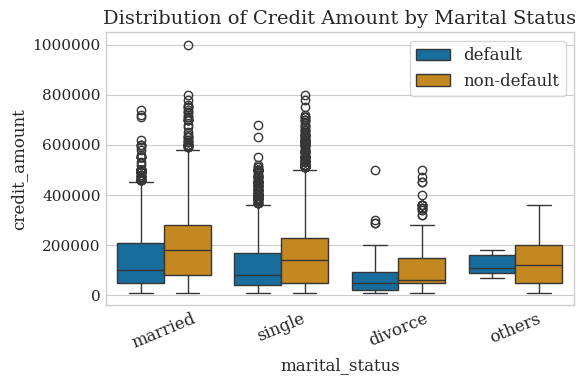

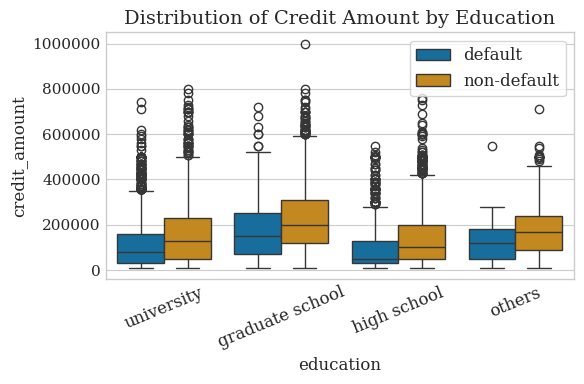

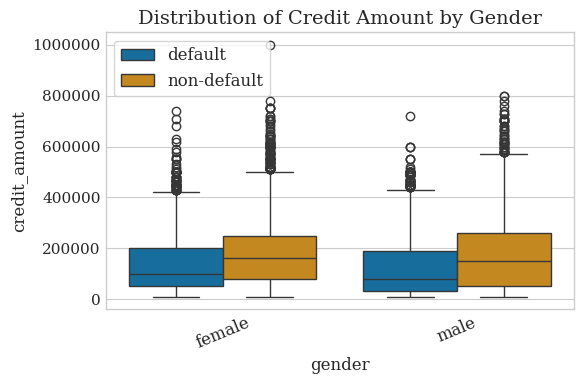

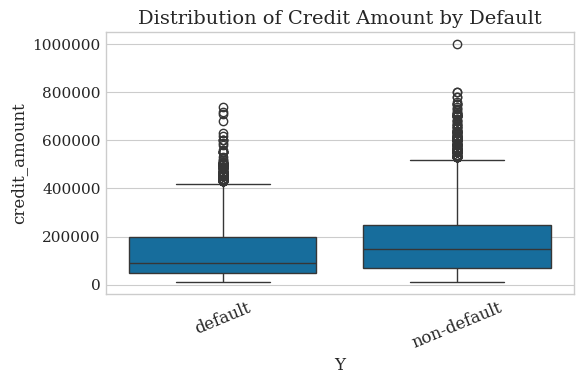

In [14]:
# We use boxplot to compare continuous data by categorical data
# credit_amount by marital_status # prefer the title 'Distribution of Credit Amount by Marital Status

plot_boxplot(data= df_eda, column= 'credit_amount', by = 'marital_status',hue='Y',title= 'Distribution of Credit Amount by Marital Status')
plot_boxplot(data= df_eda, column= 'credit_amount', by = 'education',hue='Y',title = 'Distribution of Credit Amount by Education')
plot_boxplot(data= df_eda, column= 'credit_amount', by = 'gender',hue='Y', title = 'Distribution of Credit Amount by Gender')
plot_boxplot(data= df_eda, column= 'credit_amount', by = 'Y', title = 'Distribution of Credit Amount by Default')

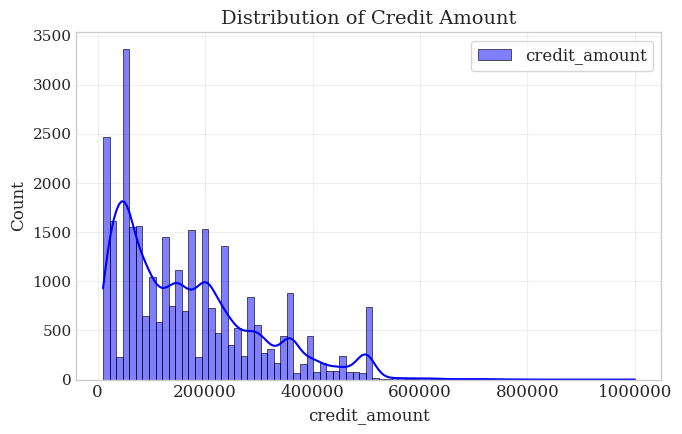

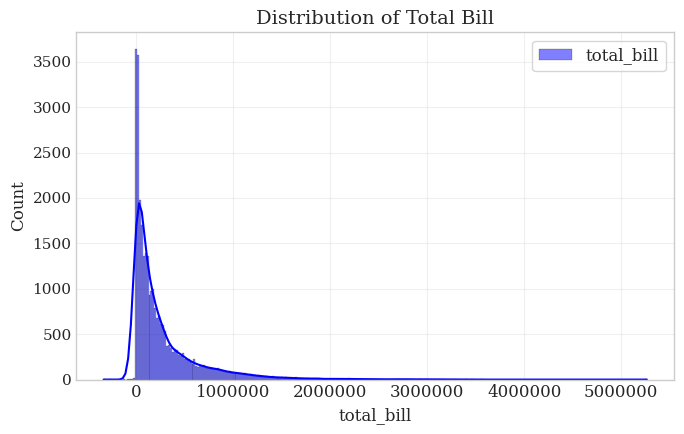

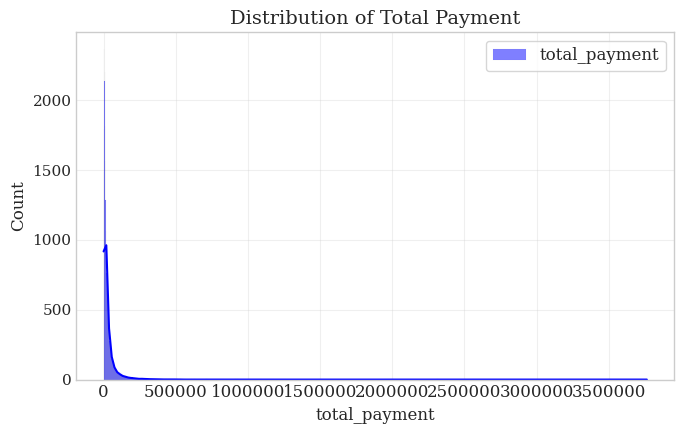

In [15]:
# Histogram for continuous variables: only credit amount was useful
'''for col in continuous_data:
    plot_histogram(data= df_eda, column = col, title = f'Histogram of {col}')'''

plot_histogram(column= 'credit_amount', title= 'Distribution of Credit Amount')
plot_histogram(column= 'total_bill', title='Distribution of Total Bill')
plot_histogram(column= 'total_payment', title='Distribution of Total Payment')

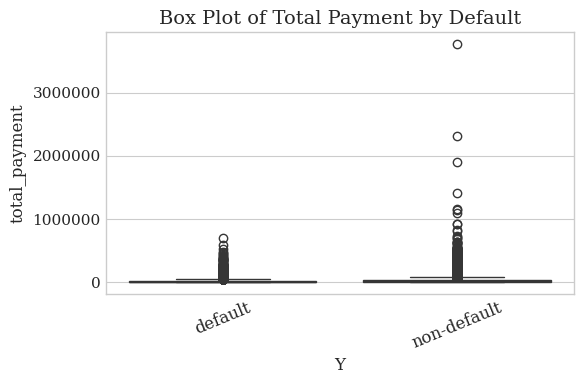

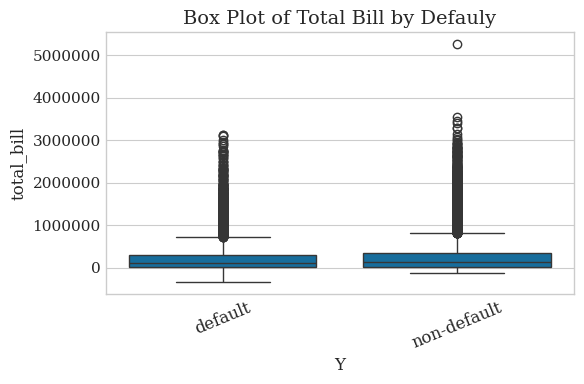

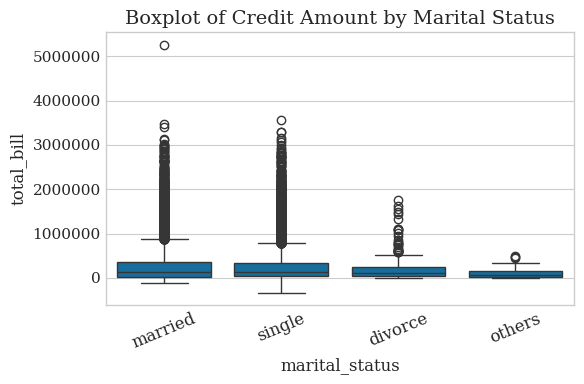

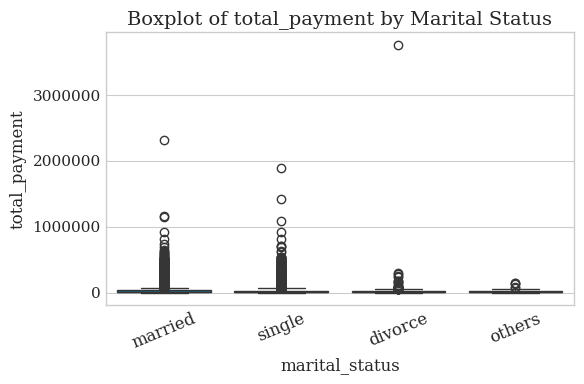

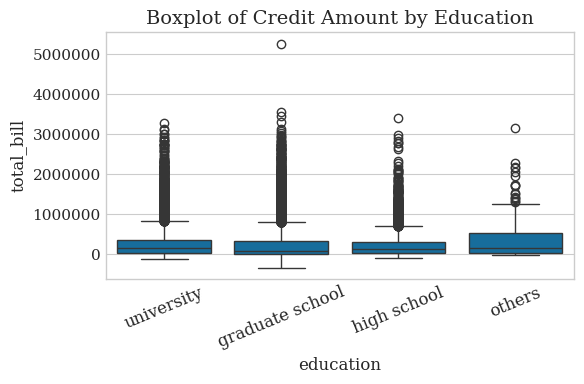

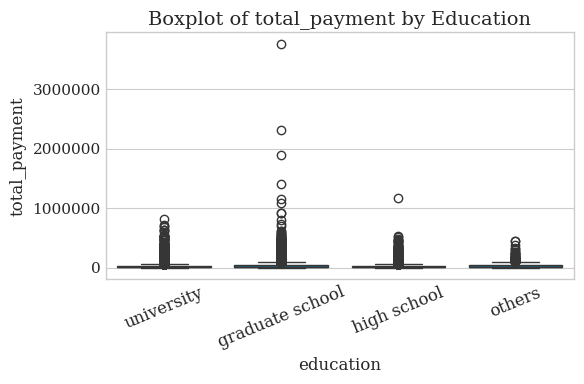

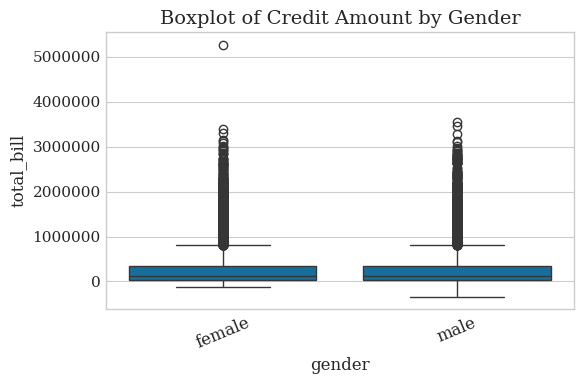

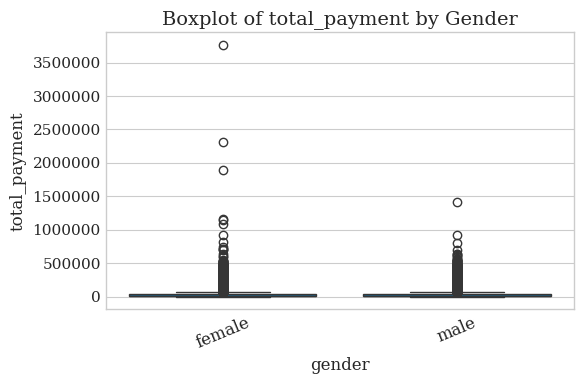

In [16]:
# We will do total bill and payment by category for boxplot. Plot continuous by categorical
# NB: Wasn't used in report
plot_boxplot(data = df_eda, column = 'total_payment', by='Y', title='Box Plot of Total Payment by Default')
plot_boxplot(data = df_eda, column = 'total_bill', by='Y', title='Box Plot of Total Bill by Defauly')


plot_boxplot(data= df_eda, column= 'total_bill', by = 'marital_status',title= 'Boxplot of Credit Amount by Marital Status')
plot_boxplot(data= df_eda, column= 'total_payment', by = 'marital_status',title= 'Boxplot of total_payment by Marital Status')


plot_boxplot(data= df_eda, column= 'total_bill', by = 'education',title = 'Boxplot of Credit Amount by Education')
plot_boxplot(data= df_eda, column= 'total_payment', by = 'education',title = 'Boxplot of total_payment by Education')

plot_boxplot(data= df_eda, column= 'total_bill', by = 'gender', title = 'Boxplot of Credit Amount by Gender')
plot_boxplot(data= df_eda, column= 'total_payment', by = 'gender', title = 'Boxplot of total_payment by Gender')


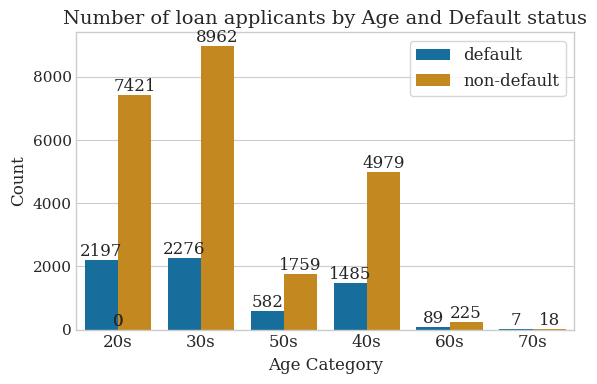

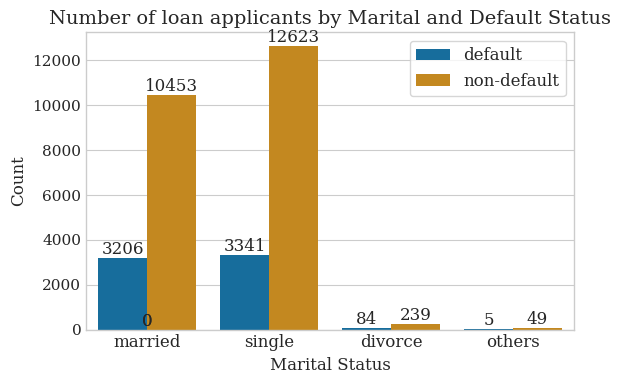

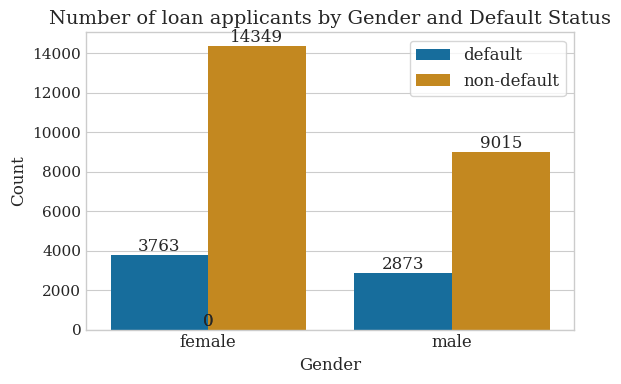

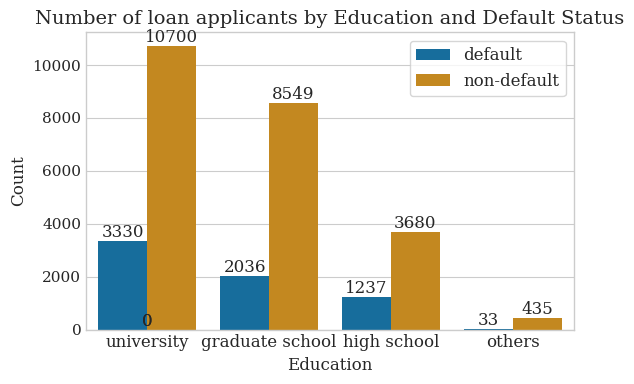

In [17]:
# Barchart by Default Status
plot_barchart(column= 'age', title= 'Number of loan applicants by Age and Default status', hue = 'Y', x_label="Age Category" ) #hue = 'Y',
plot_barchart(column= 'marital_status', title= 'Number of loan applicants by Marital and Default Status', hue = 'Y',x_label="Marital Status" )
plot_barchart(column= 'gender', title= 'Number of loan applicants by Gender and Default Status', hue = 'Y',x_label="Gender" )
plot_barchart(column= 'education', title= 'Number of loan applicants by Education and Default Status', hue = 'Y',x_label="Education" )
#plot_barchart(column= 'april_delay', title= 'Number of loan applicants by April Delay and Default Status',hue = 'Y', x_label="April", rotation= 22.5)
#plot_barchart(column= 'may_delay', title= 'Number of loan applicants by May Delay and Default Status',hue = 'Y', x_label="May", rotation= 22.5)
#plot_barchart(column= 'june_delay', title= 'Number of loan applicants by June Delay and Default Status', hue = 'Y',x_label="June", rotation= 22.5)
#plot_barchart(column= 'july_delay', title= 'Number of loan applicants by July Delay and Default Status',hue = 'Y', x_label="July", rotation= 22.5)
#plot_barchart(column= 'august_delay', title= 'Number of loan applicants by August Delay and Default Status',hue = 'Y', x_label="August", rotation= 22.5)
#plot_barchart(column= 'sept_delay', title= 'Number of loan applicants by September Delay and Default Status',hue = 'Y', x_label="September", rotation= 22.5)

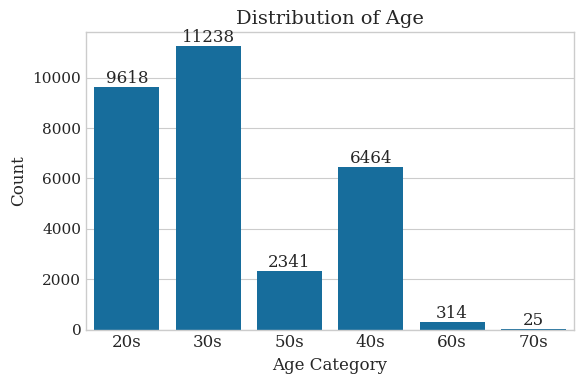

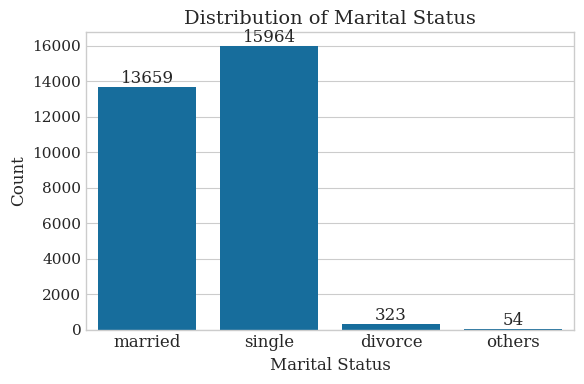

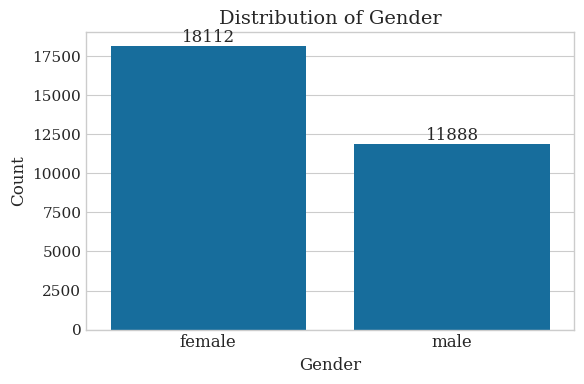

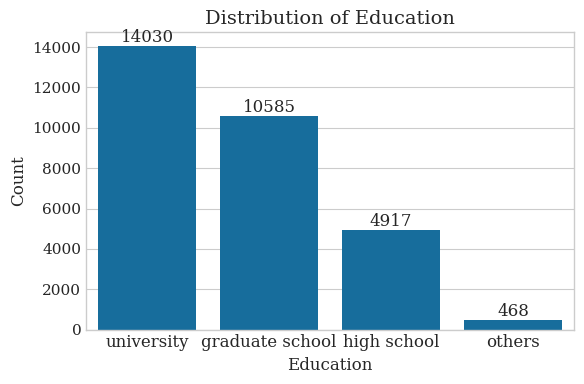

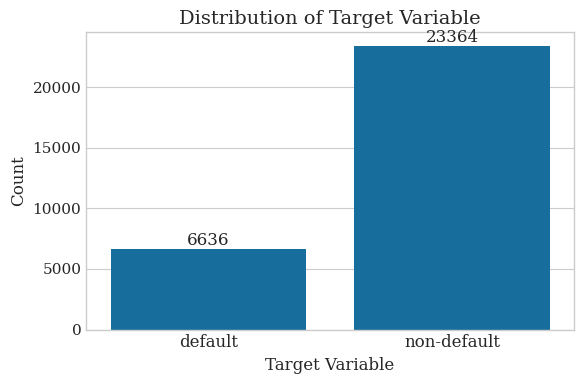

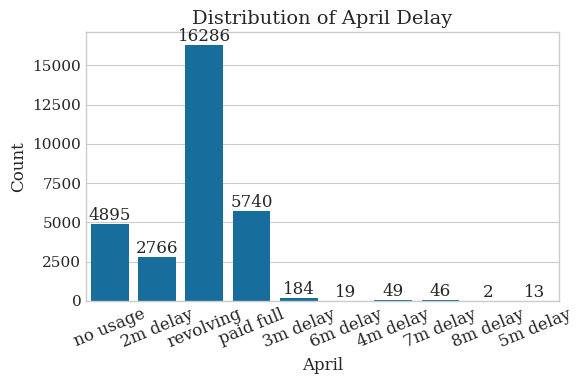

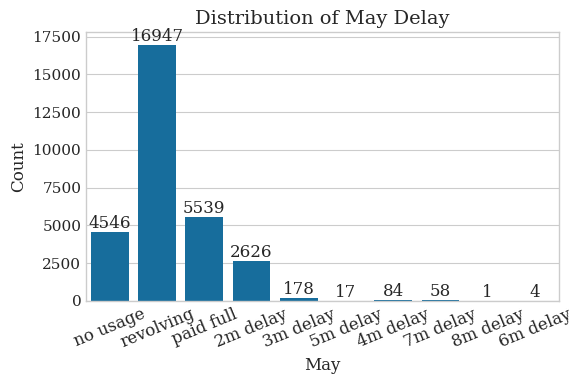

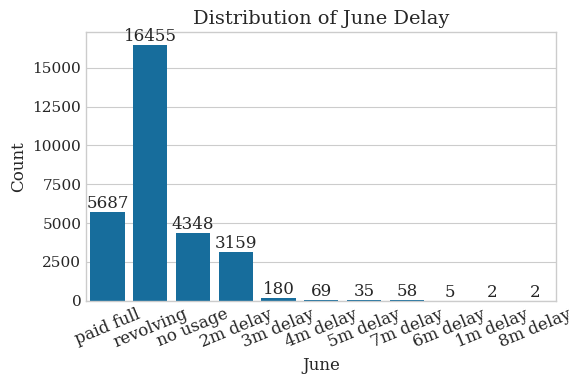

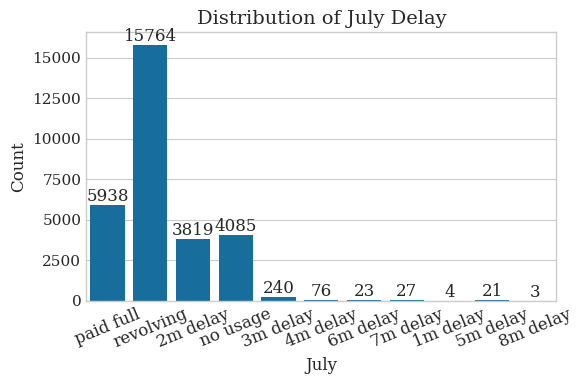

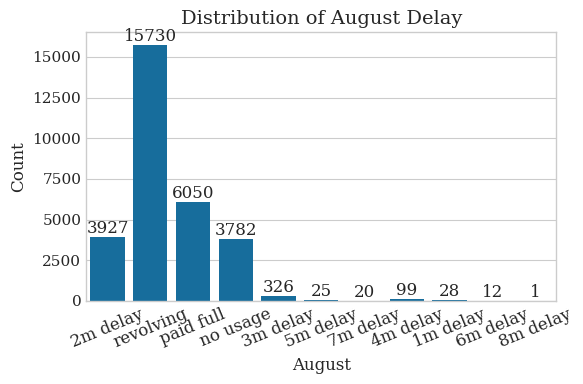

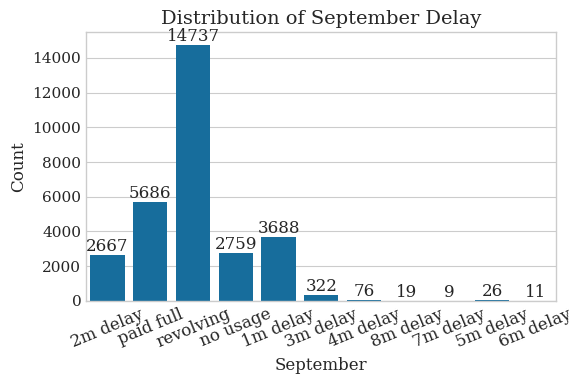

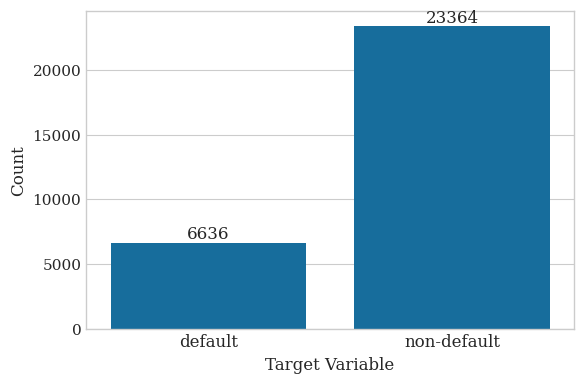

In [18]:
plot_barchart(column= 'age', title= 'Distribution of Age', x_label="Age Category" )
plot_barchart(column= 'marital_status', title= 'Distribution of Marital Status', x_label="Marital Status" )
plot_barchart(column= 'gender', title= 'Distribution of Gender', x_label="Gender" )
plot_barchart(column= 'education', title= 'Distribution of Education', x_label="Education" )
plot_barchart(column= 'Y', title= 'Distribution of Target Variable', x_label="Target Variable" )

# Delays
plot_barchart(column= 'april_delay', title= 'Distribution of April Delay', x_label="April", rotation= 22.5)
plot_barchart(column= 'may_delay', title= 'Distribution of May Delay', x_label="May", rotation= 22.5)
plot_barchart(column= 'june_delay', title= 'Distribution of June Delay', x_label="June", rotation= 22.5)
plot_barchart(column= 'july_delay', title= 'Distribution of July Delay', x_label="July", rotation= 22.5)
plot_barchart(column= 'august_delay', title= 'Distribution of August Delay', x_label="August", rotation= 22.5)
plot_barchart(column= 'sept_delay', title= 'Distribution of September Delay', x_label="September", rotation= 22.5)

plot_barchart(column= 'Y', x_label="Target Variable" )

In [19]:
# plots used in report
'''
plot_barchart(column= 'Y', x_label="Target Variable",save= True )
plot_barchart(column= 'education',  x_label="Education", save=True )
plot_barchart(column= 'marital_status', x_label="Marital Status",save=True )
plot_barchart(column= 'gender', hue = 'Y',x_label="Gender", save=True )
plot_barchart(column= 'age', save=True, x_label="Age Category" ) #hue = 'Y',
plot_boxplot(data= df_eda, column= 'credit_amount', by = 'marital_status',hue='Y',save=True)
plot_boxplot(data= df_eda, column= 'credit_amount', by = 'education',hue='Y',save=True)
plot_boxplot(data= df_eda, column= 'credit_amount', by = 'gender',hue='Y',save=True)
plot_boxplot(data= df_eda, column= 'credit_amount', by = 'Y',save=True)
'''


'\nplot_barchart(column= \'Y\', x_label="Target Variable",save= True )\nplot_barchart(column= \'education\',  x_label="Education", save=True )\nplot_barchart(column= \'marital_status\', x_label="Marital Status",save=True )\nplot_barchart(column= \'gender\', hue = \'Y\',x_label="Gender", save=True )\nplot_barchart(column= \'age\', save=True, x_label="Age Category" ) #hue = \'Y\',\nplot_boxplot(data= df_eda, column= \'credit_amount\', by = \'marital_status\',hue=\'Y\',save=True)\nplot_boxplot(data= df_eda, column= \'credit_amount\', by = \'education\',hue=\'Y\',save=True)\nplot_boxplot(data= df_eda, column= \'credit_amount\', by = \'gender\',hue=\'Y\',save=True)\nplot_boxplot(data= df_eda, column= \'credit_amount\', by = \'Y\',save=True)\n'

In [20]:
month_delays =  [
    'july_delay',
    'august_delay',
    'gender',
    'may_delay',
    'april_delay',
    'june_delay',
    'sept_delay'
    ]
for column in month_delays:
    print('='*50)
    print(df_eda[column].value_counts())

july_delay
revolving    15764
paid full     5938
no usage      4085
2m delay      3819
3m delay       240
4m delay        76
7m delay        27
6m delay        23
5m delay        21
1m delay         4
8m delay         3
Name: count, dtype: int64
august_delay
revolving    15730
paid full     6050
2m delay      3927
no usage      3782
3m delay       326
4m delay        99
1m delay        28
5m delay        25
7m delay        20
6m delay        12
8m delay         1
Name: count, dtype: int64
gender
female    18112
male      11888
Name: count, dtype: int64
may_delay
revolving    16947
paid full     5539
no usage      4546
2m delay      2626
3m delay       178
4m delay        84
7m delay        58
5m delay        17
6m delay         4
8m delay         1
Name: count, dtype: int64
april_delay
revolving    16286
paid full     5740
no usage      4895
2m delay      2766
3m delay       184
4m delay        49
7m delay        46
6m delay        19
5m delay        13
8m delay         2
Name: count, 

In [21]:
len(df_eda.columns)

26

<Figure size 1500x800 with 0 Axes>

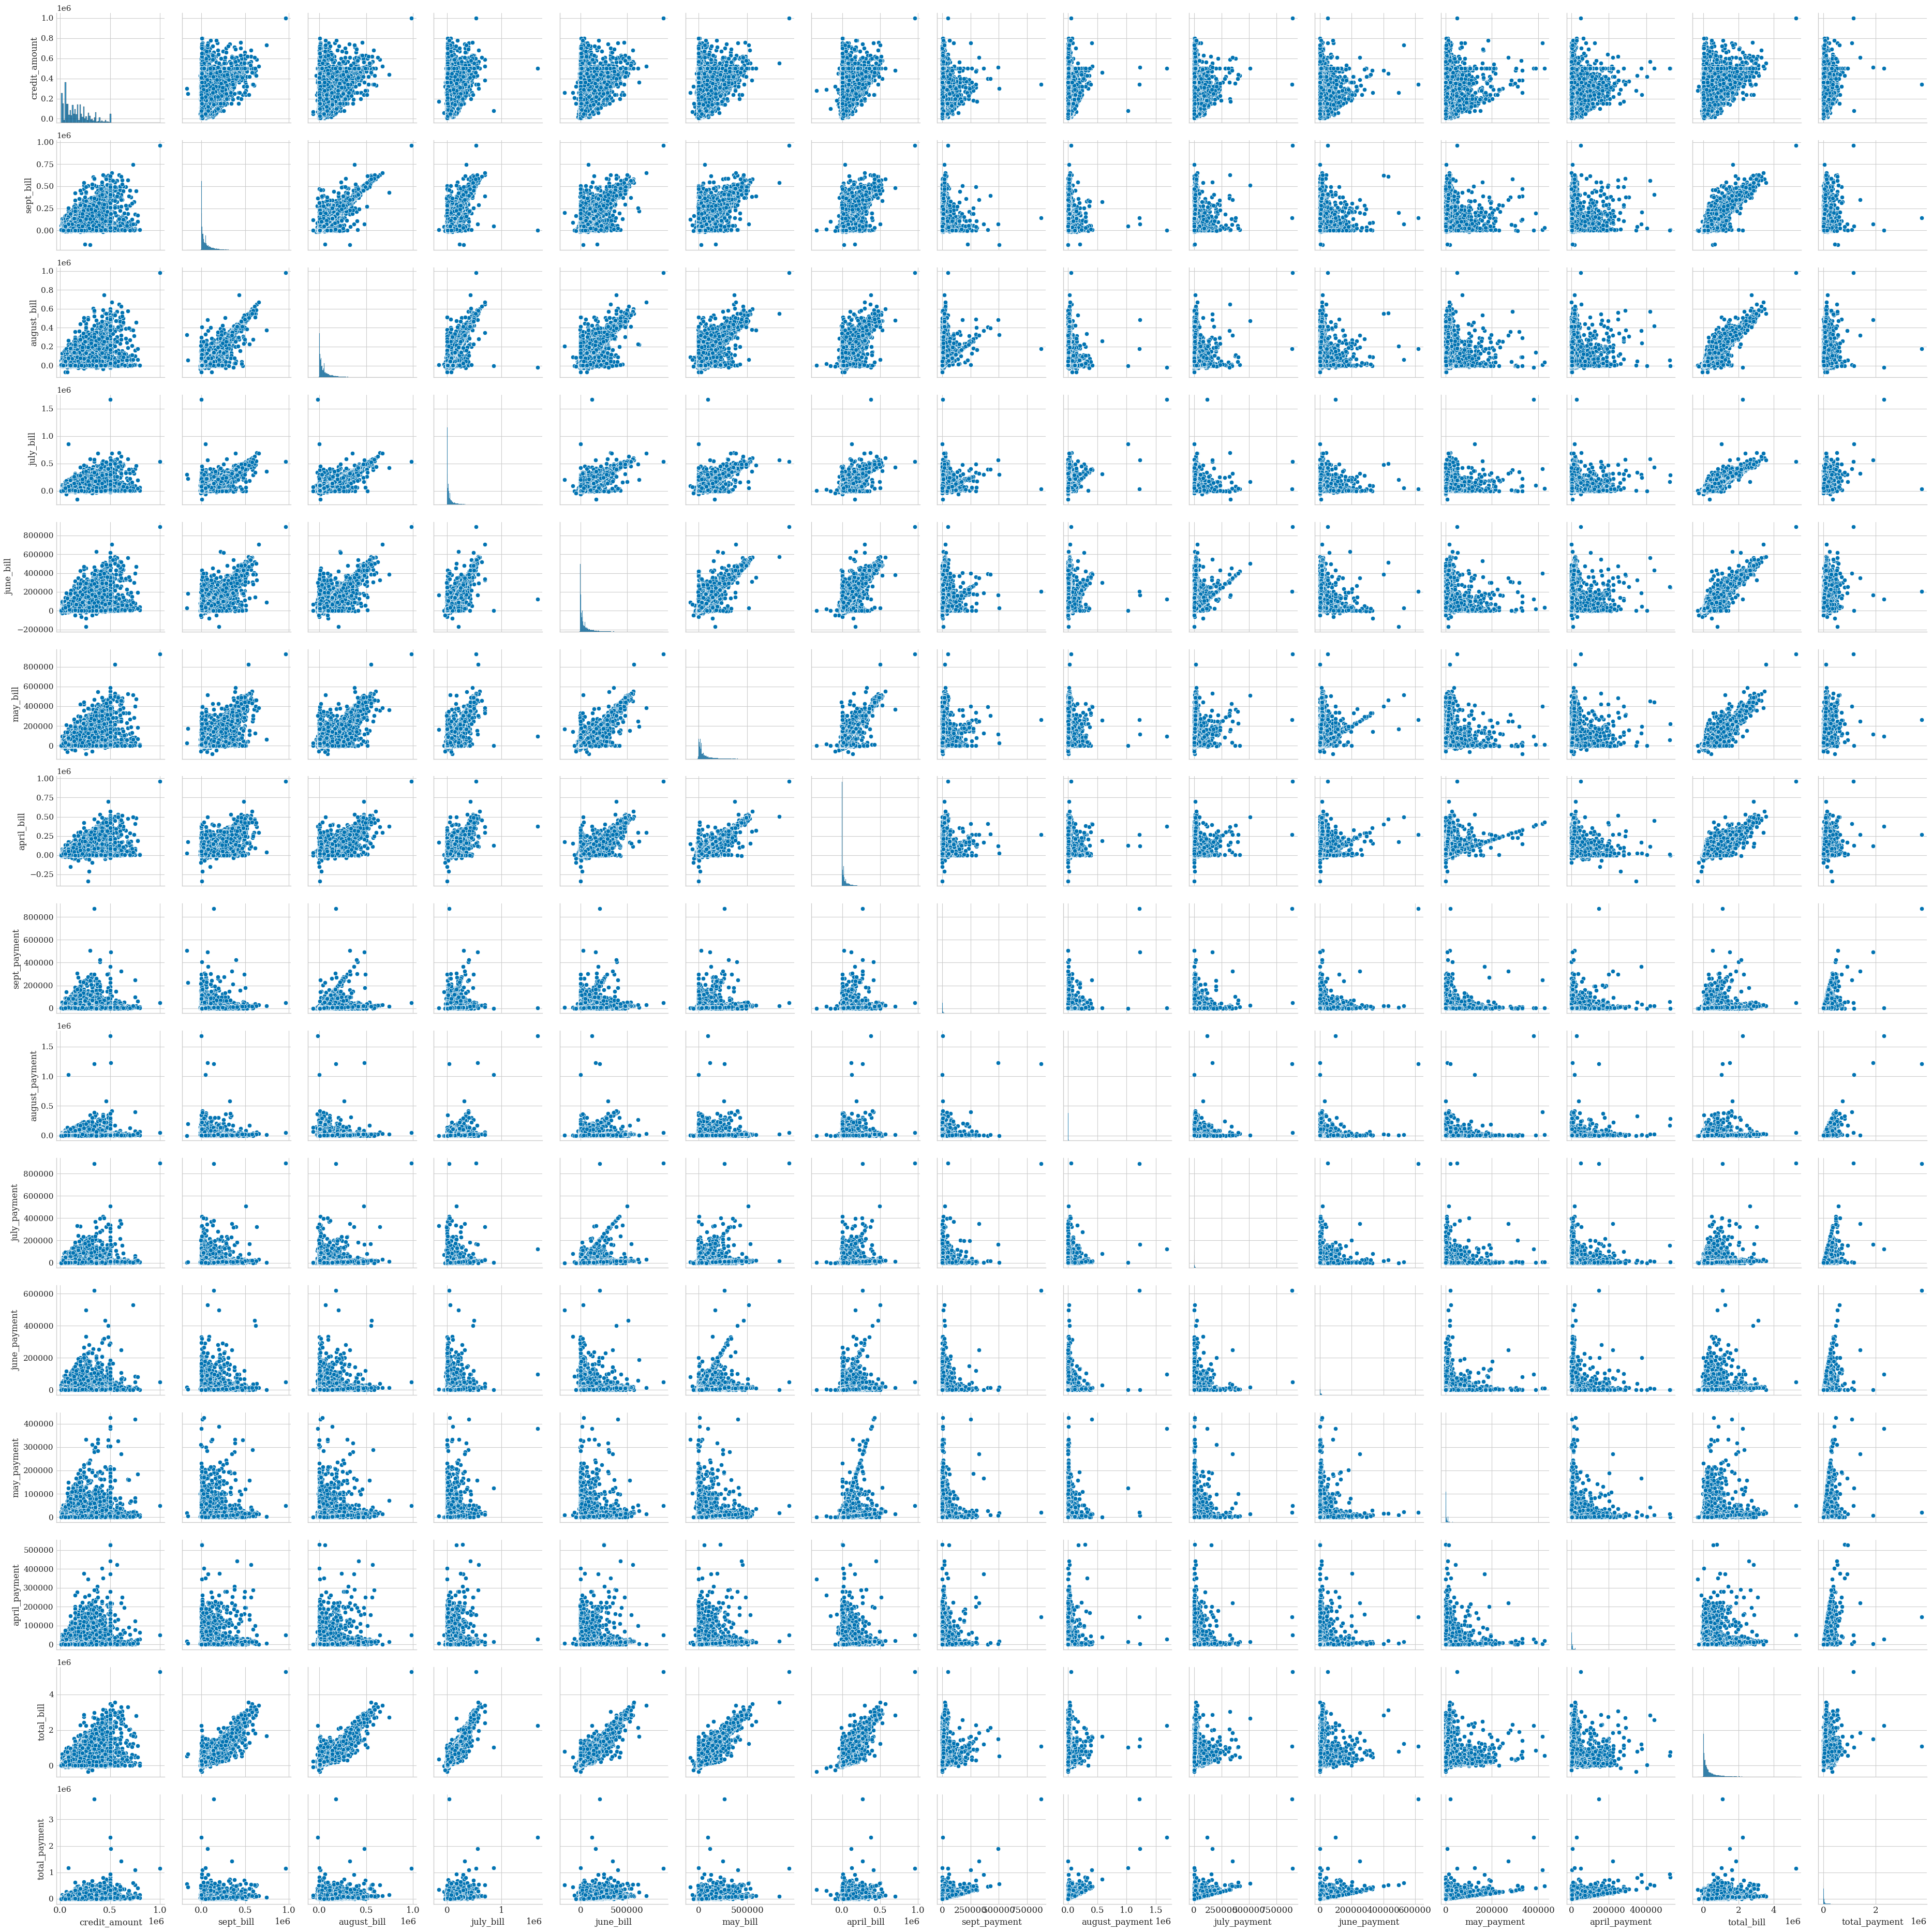

In [22]:
plt.figure(figsize=(15, 8))
sns.pairplot(df_eda)
plt.tight_layout()
plt.show()

## 3. Prepare Data for Machine Learning Algorithms
---

This involves cleaning the dataset, removing duplicates and and ensuring the dataset in consistent with appropriate data types. The dataframe used here is the `df` not `df_eda` that was specially created for the exploratory data analysis.

1. Data Cleaning: The Data cleaning steps we under took were as follows
    - Remove Duplicates
    - Handle null variabes
    - Fix datatypes
    - Handle inconsistent data e.g changing entries into uniform format by correcting misspellings

2. Feature Engineering: Our feature engineering involved the creation of two additional features `payment consistency`, `total_delays` and the transformation of the `credit_amount` feature using np.sqrt. Other steps were 
    - Standardise continuous features
    - Convert categorrical data into numbers
        - Labelencoder: For target variable
        - Ordinal Encoder: For variables that have order e.g education
        - One hot encoding: For categories that have no implicit order e.g color
3. Data Preprocessing:   
    - Normalisation (aka feature scaling): Convert data into similar scales to assist some machine learning models using Standard Scaler.

### 3.1 Data Cleaning
---

    - Remove Duplicates
    - Handle null variabes
    - Fix datatypes
    - Handle inconsistent data such as changing entries into uniform format


In [23]:
# Save original df
original_df = df.copy() 


In [24]:
# Check for duplicates
print(f"The number of duplicate entries is {df.duplicated().sum()}.")

# drop duplicates
df = df.drop_duplicates()
print(f"Duplicates Dropped: duplicate entries = {df.duplicated().sum()}.")

# We will need this to check effect of feature engineering
raw_df = df.copy() 
raw_df.columns

The number of duplicate entries is 35.
Duplicates Dropped: duplicate entries = 0.


Index(['credit_amount', 'gender', 'education', 'marital_status', 'age',
       'sept_delay', 'august_delay', 'july_delay', 'june_delay', 'may_delay',
       'april_delay', 'sept_bill', 'august_bill', 'july_bill', 'june_bill',
       'may_bill', 'april_bill', 'sept_payment', 'august_payment',
       'july_payment', 'june_payment', 'may_payment', 'april_payment', 'Y'],
      dtype='object')

In [25]:
# lets check datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29965 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   credit_amount   29965 non-null  int64
 1   gender          29965 non-null  int64
 2   education       29965 non-null  int64
 3   marital_status  29965 non-null  int64
 4   age             29965 non-null  int64
 5   sept_delay      29965 non-null  int64
 6   august_delay    29965 non-null  int64
 7   july_delay      29965 non-null  int64
 8   june_delay      29965 non-null  int64
 9   may_delay       29965 non-null  int64
 10  april_delay     29965 non-null  int64
 11  sept_bill       29965 non-null  int64
 12  august_bill     29965 non-null  int64
 13  july_bill       29965 non-null  int64
 14  june_bill       29965 non-null  int64
 15  may_bill        29965 non-null  int64
 16  april_bill      29965 non-null  int64
 17  sept_payment    29965 non-null  int64
 18  august_payment  29965 non-null 

### 3.2 Feature Engineering
---
- Feature Engineering
    - Standardise numerical continuous features
    - Convert category into numbers
        - Labelencoder: For target variable
        - Ordinal Encoder: For variables that have order
        for data that has order (no!) we use label encoder for
    - Convert category into numbers (one hot encoding) for categories that have no order e.g green, red, white
    - Normalisation (aka feature scaling) Cinvert data into equal scales (standard scaler, etc)
    - Feature creatinon/combination
    - Transform features `np.log()` or `np.log2()` for datasets to mirror gaussian distribution

In [26]:
# Edit categorical and continuos lists
categorical_data.remove('age')
categorical_data.remove('Y')
continuous_data.append('age')

print(f'Continuous\n{continuous_data}\n')
print('='*50)
print(f'Categorical\n{categorical_data}')

Continuous
['credit_amount', 'sept_bill', 'august_bill', 'july_bill', 'june_bill', 'may_bill', 'april_bill', 'sept_payment', 'august_payment', 'july_payment', 'june_payment', 'may_payment', 'april_payment', 'age']

Categorical
['gender', 'education', 'april_delay', 'marital_status', 'august_delay', 'june_delay', 'sept_delay', 'july_delay', 'may_delay']


#### 3.2.1 Handling Continuous Data
---

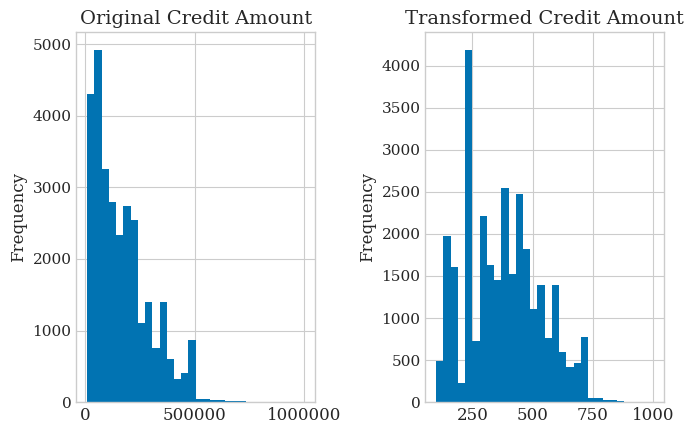

In [27]:
# plot to show credit column before and after transformation
fig, ax = plt.subplots(1,2, figsize = (7,4.5))

# First Plot
df['credit_amount'].plot(kind = 'hist', bins = 30, ax= ax[0])
ax[0].ticklabel_format(style='plain', axis='x')
ax[0].set_title('Original Credit Amount')

# second plot 
np.sqrt(df['credit_amount']+1).plot(kind = 'hist', bins = 30, ax = ax[1]) # looks a bit gaussian
#np.log(X_train['credit_amount']).plot(kind = 'hist', bins = 30, ax = ax[1])
ax[1].set_title('Transformed Credit Amount')
plt.tight_layout()
plt.savefig(fname = 'transf', 
        dpi=300, 
        bbox_inches='tight',    
        pad_inches=0.1,         
        facecolor='white')
plt.show()

In [28]:
months = ['april', 
          'may', 
          'june', 
          'july', 
          'august', 
          'sept'
          ]


for month in months:
  print(f"The minimum bill value for {month} is {df[f'{month}_bill'].min()}" ) # why are there negative bill amounts

print('='*50)
print('='*50)

for month in months:
  print(f"The minimum payment value for {month} is {df[f'{month}_payment'].min()}" ) 


The minimum bill value for april is -339603
The minimum bill value for may is -81334
The minimum bill value for june is -170000
The minimum bill value for july is -157264
The minimum bill value for august is -69777
The minimum bill value for sept is -165580
The minimum payment value for april is 0
The minimum payment value for may is 0
The minimum payment value for june is 0
The minimum payment value for july is 0
The minimum payment value for august is 0
The minimum payment value for sept is 0


In [29]:
delay_cols = [f'{month}_delay' for month in months]

df['payment_consistency'] = df[['sept_payment', 
                                'august_payment', 
                                'july_payment', 
                                'june_payment', 
                                'may_payment', 
                                'april_payment']].std(axis=1)


df['total_delays'] = df[delay_cols].sum(axis=1)

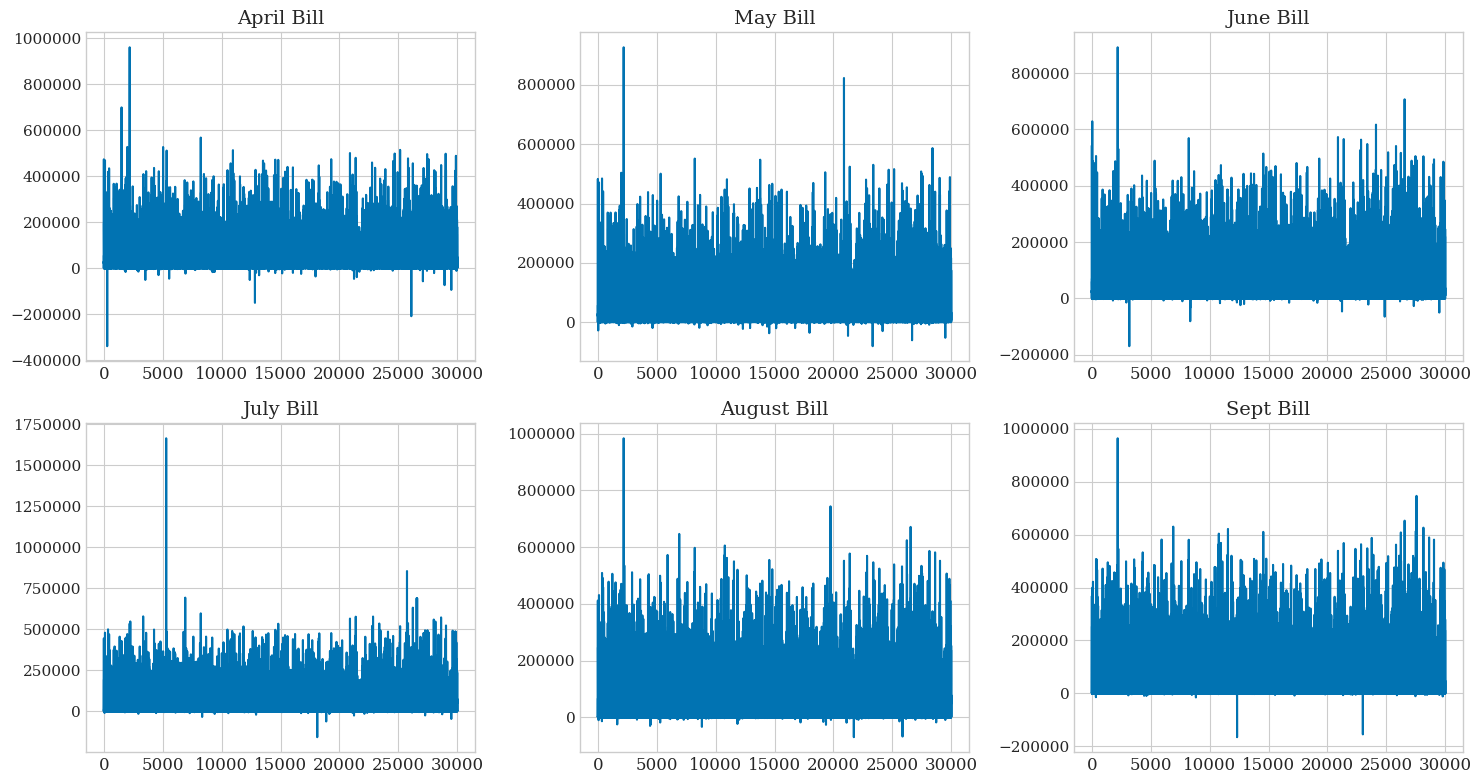

In [30]:
# Let's show the a line chart of the bill to get a feel for the minuses 
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()  # Flatten to easily index with [index]

for index, month in enumerate(months):
    df[f'{month}_bill'].plot(kind='line', ax=axes[index], title=f'{month.capitalize()} Bill')
    axes[index].ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

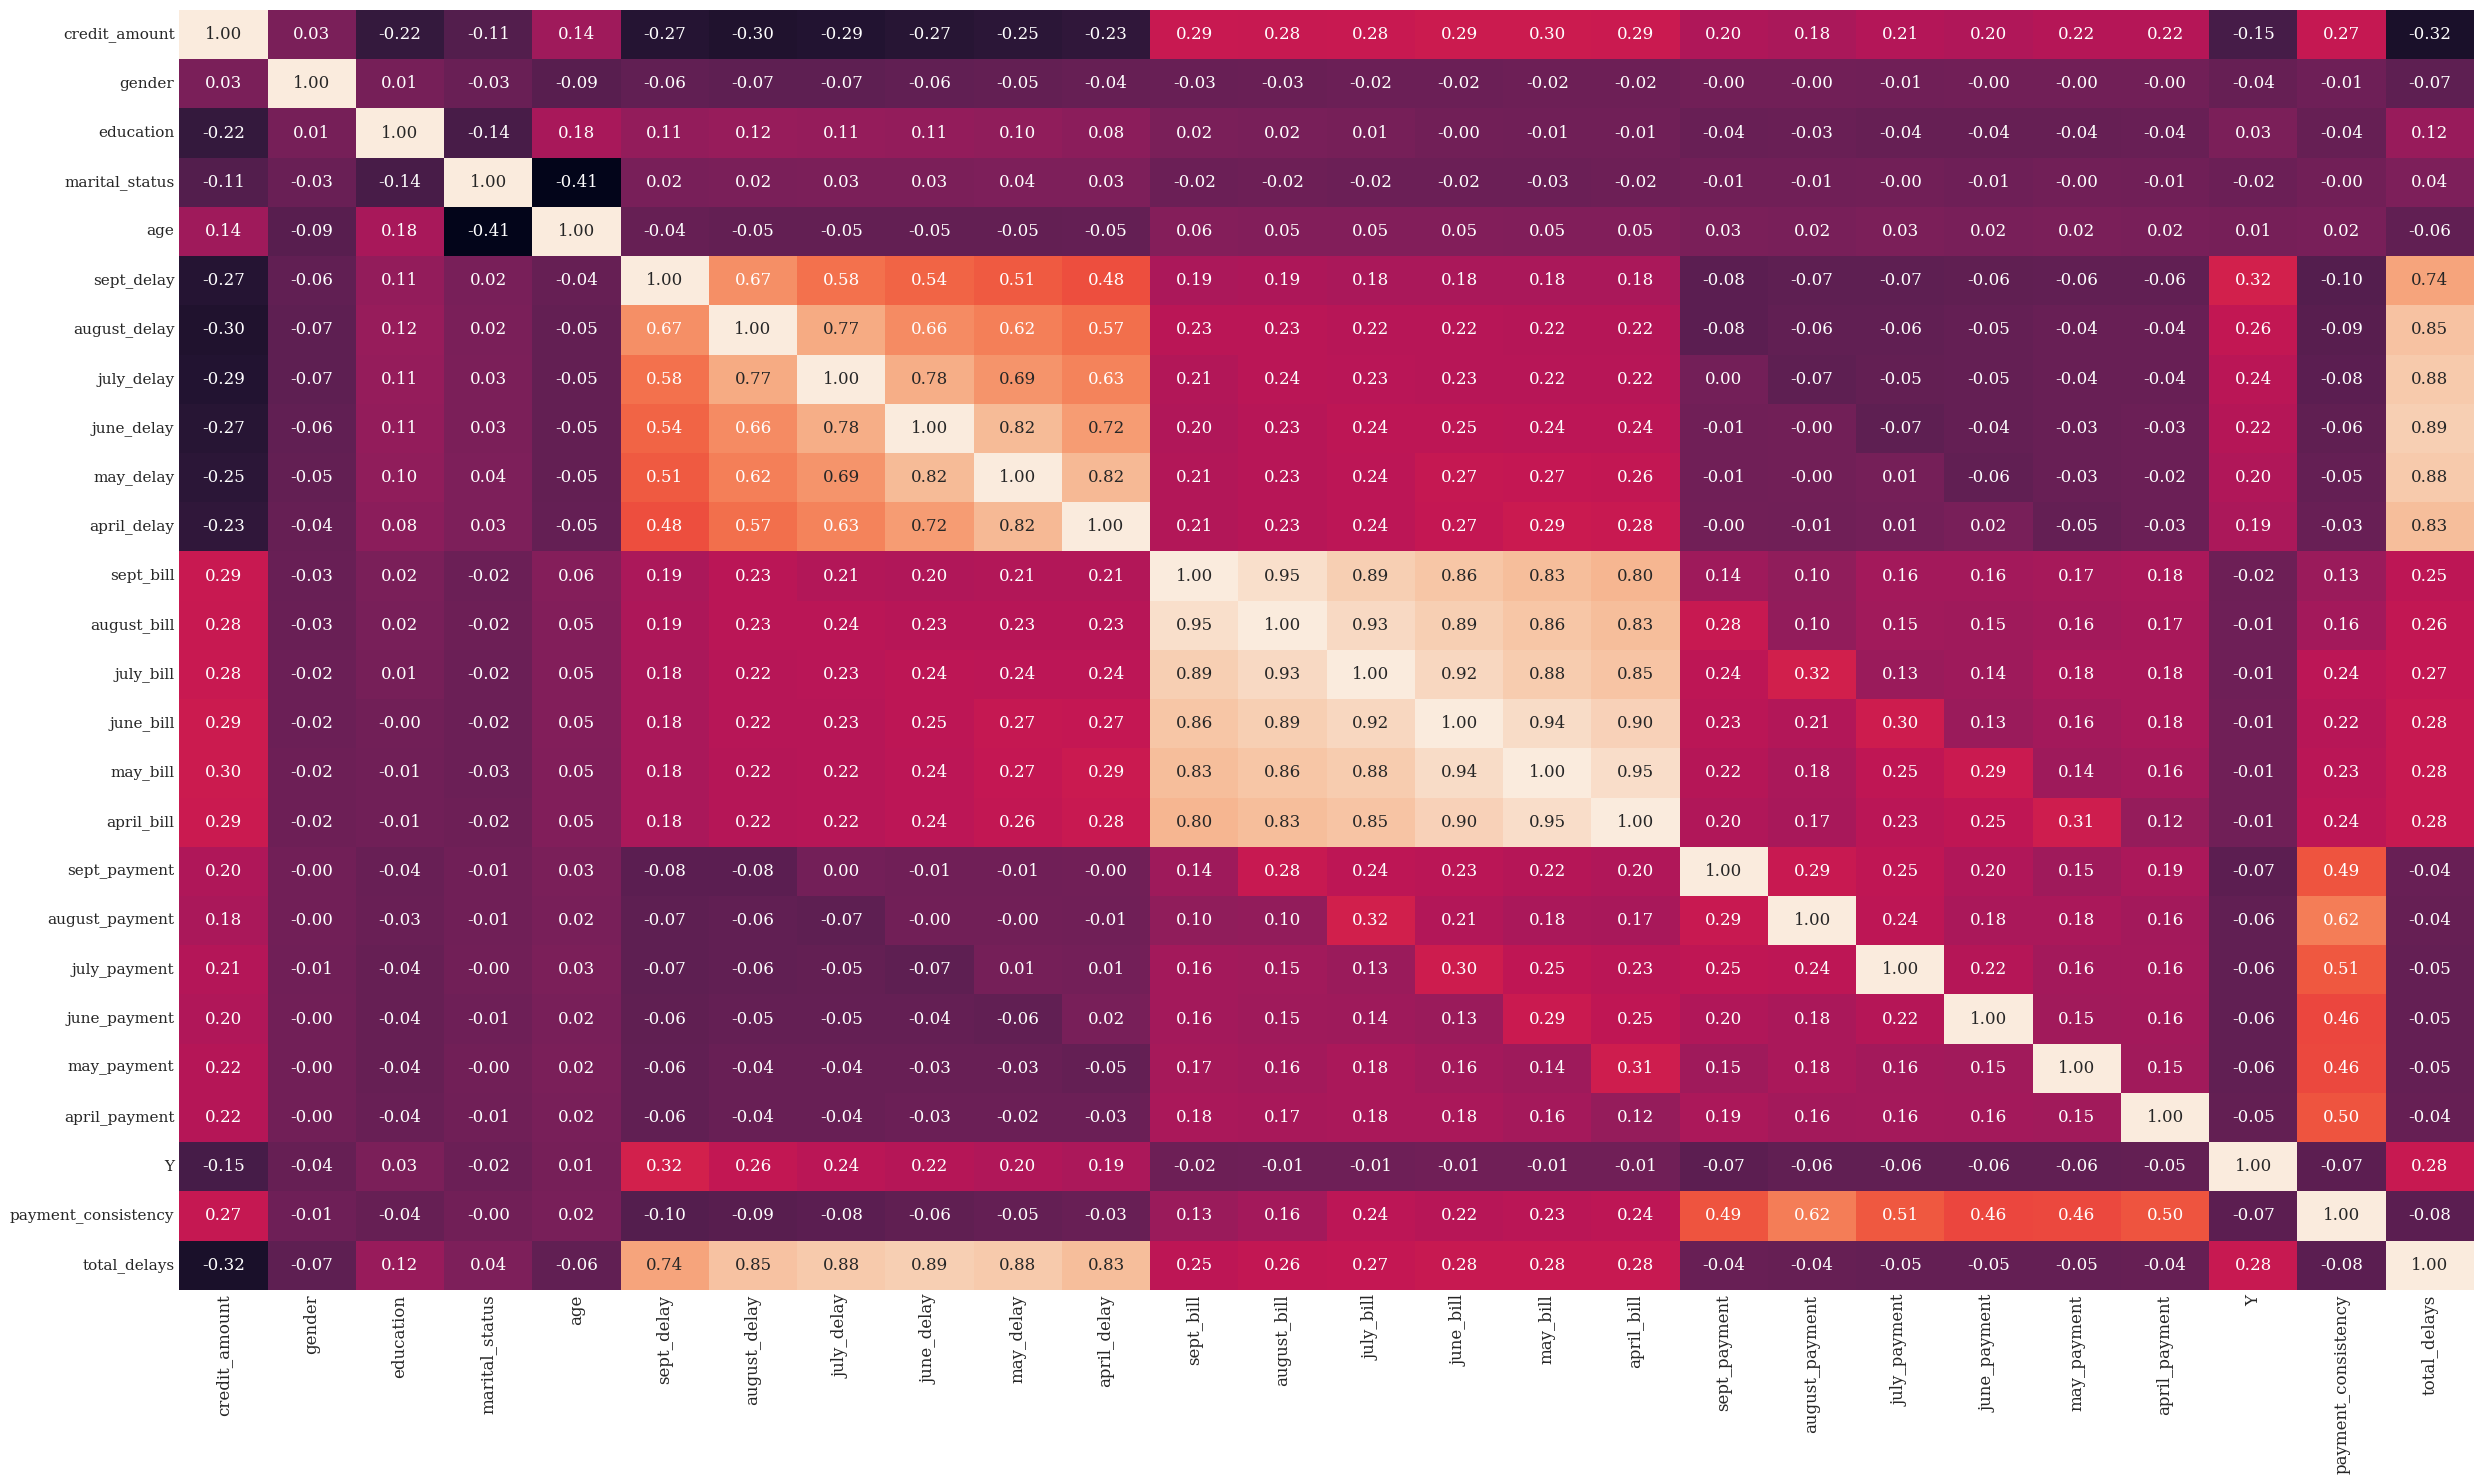

In [31]:
# now we have 26 columns
df.shape 

# Show overall correlation
plt.figure(figsize= (25,15))
sns.heatmap(df.corr(), fmt= '.2f', annot= True, cbar= False)
plt.tight_layout()
plt.show()

In [32]:
# The month bills and month delays are highly correlated
bill_cols  = [f'{month}_bill' for month in months]
df[delay_cols  +['total_delays','Y']].corr()

april_delay  may_delay  june_delay  july_delay  august_delay  \
april_delay      1.000000   0.816387    0.715663    0.631665      0.574433   
may_delay        0.816387   1.000000    0.819322    0.685882      0.621810   
june_delay       0.715663   0.819322    1.000000    0.776731      0.661205   
july_delay       0.631665   0.685882    0.776731    1.000000      0.765965   
august_delay     0.574433   0.621810    0.661205    0.765965      1.000000   
sept_delay       0.475468   0.510455    0.539928    0.575420      0.673592   
total_delays     0.829832   0.877184    0.890709    0.877765      0.850106   
Y                0.186740   0.204059    0.216551    0.235230      0.263656   

              sept_delay  total_delays         Y  
april_delay     0.475468      0.829832  0.186740  
may_delay       0.510455      0.877184  0.204059  
june_delay      0.539928      0.890709  0.216551  
july_delay      0.575420      0.877765  0.235230  
august_delay    0.673592      0.850106  0.263656  
sept_delay      1.000000      0.742584  0.324964  
total_delays    0.742584      1.000000  0.281989  
Y               0.324964      0.281989  1.000000

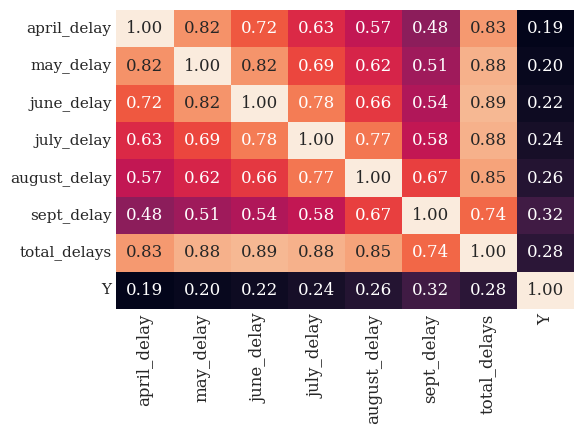

In [33]:
plt.figure(figsize= (6,4.5))
sns.heatmap(df[delay_cols  +[ 'total_delays', 'Y']].corr(), fmt= '.2f', annot= True ,cbar= False)
plt.tight_layout()
plt.show()

# we will drop all the delays apart from september, august, july and total_delays 
# as they all correlated well with themeselves and the target variable.

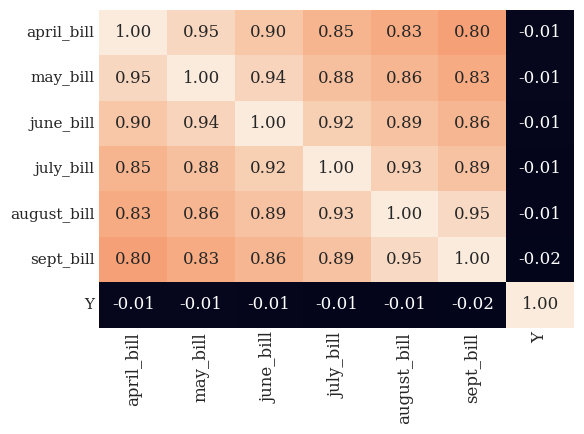

In [34]:
plt.figure(figsize= (6,4.5))
sns.heatmap(df[bill_cols  +['Y']].corr(), fmt= '.2f', annot= True, cbar= False)
plt.tight_layout()
plt.show()
# since I have already used bill payment to craft another feature payment Ratio,
# Let me just keep the most recent three month #september _bill and drop the rest
# we will drop all the delays apart from september and total_delays 

In [35]:
# save transformed data
transformed_copy = df.copy()

In [36]:
# Let me just keep the most recent month #september _bill and drop the rest
# We will drop all the delays apart from september and total_delays 
columns_to_drop = [ 
    'june_bill',
    'may_bill',
    'april_bill', 
    'june_delay', 
    'may_delay',
    'april_delay'
    ]

In [37]:
print(len(df.columns))
df = df.drop(columns = columns_to_drop)
print(len(df.columns))

26
20


In [38]:
# redefinition of continuous and categorical_data
continuous_data =['credit_amount',
                   'age', 
                   'sept_bill', 
                   'august_bill',
                   'july_bill', 
                   'sept_payment', 
                   'august_payment', 
                   'july_payment',
                   'june_payment',
                   'may_payment', 
                   'april_payment',
                   'payment_consistency'
                   ]

categorical_data = ['gender',
                    'education',
                    'marital_status',
                    'sept_delay', 
                    'august_delay', 
                    'july_delay',
                    'total_delays'
                    ]


# redefinition of continuous and categorical_data FOR RAW

raw_continuous_data = [
    'credit_amount',
    'age',
    'sept_bill',
    'august_bill',
    'july_bill',
    'june_bill',
    'may_bill',
    'april_bill',
    'sept_payment',
    'august_payment',
    'july_payment',
    'june_payment',
    'may_payment',
    'april_payment'
    ]

# for raw data
raw_categorical_data = [
    'july_delay',
    'marital_status', 
    'june_delay', 
    'sept_delay', 
    'may_delay', 
    'april_delay', 
    'august_delay', 
    'education', 
    'gender']

#### 3.2.3 Splitting into Train Test
---
This was done here to prevent data leakage from the train set into the test set.

In [39]:
y = df['Y']
X = df.drop(columns = "Y")

y_raw = raw_df["Y"]
X_raw = raw_df.drop(columns = "Y")

In [40]:
# I must apply processing techniques only on train data
# random_state = 70 everywhere
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify= y,
                                                    train_size=0.7, 
                                                    random_state= random_state)

X_train_raw,X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw,y_raw,
                                                                   stratify=y_raw,
                                                                   train_size=0.7,
                                                                   random_state=random_state)

**Transformed data** 

In [41]:
# Transformed Data
print("===== Continuous Features before Scaling =====")
print(X_train[continuous_data].head())

# init scaler
trf_scaler = StandardScaler()

# fit on training data
trf_scaler.fit(X_train[continuous_data])
X_train[continuous_data] = trf_scaler.transform(X_train[continuous_data])


print("===== Continuous Features after Scaling =====")
print(X_train[continuous_data].head())

# Now I will transform the test data with values learned from train data
print("===== Continuous Features before Scaling (Test Data) =====")
print(X_test[continuous_data].head())
X_test[continuous_data] = trf_scaler.transform(X_test[continuous_data])


print("===== Continuous Features after Scaling (Test Data) =====")
print(X_test[continuous_data].head())


# init  and fit scaler on training dataset
raw_scaler = StandardScaler()
raw_scaler.fit(X_train_raw[raw_continuous_data])
# transform raw train and test data
X_train_raw[raw_continuous_data] = raw_scaler.transform(X_train_raw[raw_continuous_data])
X_test_raw[raw_continuous_data] = raw_scaler.transform(X_test_raw[raw_continuous_data])

===== Continuous Features before Scaling =====
       credit_amount  age  sept_bill  august_bill  july_bill  sept_payment  \
3355          380000   48     363191       373421     363343         15504   
28151         300000   32     169223       179223     199223         10000   
8934          330000   34        901            0          0             0   
13540         100000   28      10000            0          0             0   
14378          50000   26      41827        42650      45930          1800   

       august_payment  july_payment  june_payment  may_payment  april_payment  \
3355            14000         12500         12000        11000          14000   
28151           20000         11022          4935            6           2844   
8934                0             0             0            0              0   
13540               0             0             0            0              0   
14378            4000             0          3500         2000              0  

===== Continuous Features after Scaling =====
       credit_amount       age  sept_bill  august_bill  july_bill  \
3355        1.627653  1.349715   4.250262     4.573655   4.543440   
28151       1.014662 -0.379368   1.611526     1.838360   2.188173   
8934        1.244533 -0.163232  -0.678323    -0.686012  -0.670854   
13540      -0.517817 -0.811639  -0.554540    -0.686012  -0.670854   
14378      -0.900937 -1.027774  -0.121567    -0.085283  -0.011717   

       sept_payment  august_payment  july_payment  june_payment  may_payment  \
3355       0.575387        0.307912      0.378597      0.449329     0.389037   
28151      0.252055        0.542256      0.300221      0.004822    -0.310951   
8934      -0.335393       -0.238892     -0.284265     -0.305672    -0.311334   
13540     -0.335393       -0.238892     -0.284265     -0.305672    -0.311334   
14378     -0.229652       -0.082662     -0.284265     -0.085463    -0.183993   

       april_payment  payment_consistency  
3355        0.

#### 3.2.2 Handle Categorical Data
---

In [42]:
print(categorical_data)
print('='*100)
X_train[categorical_data]

['gender', 'education', 'marital_status', 'sept_delay', 'august_delay', 'july_delay', 'total_delays']


gender  education  marital_status  sept_delay  august_delay  \
3355        2          2               1           0             0   
28151       2          1               2           0             0   
8934        1          2               1          -1            -1   
13540       1          2               1          -1            -1   
14378       1          3               2           2             0   
...       ...        ...             ...         ...           ...   
27754       2          1               2           1             2   
316         2          2               2           0             0   
4390        2          2               2           0             0   
10422       2          1               2           0            -1   
21010       1          2               1           0             0   

       july_delay  total_delays  
3355            0             0  
28151           0             0  
8934           -2           -10  
13540          -2           -10  
14378           0             8  
...           ...           ...  
27754           0             3  
316             0             0  
4390            0            -4  
10422           0            -1  
21010           0            -1  

[20975 rows x 7 columns]

Y
0    0.778737
1    0.221263
Name: proportion, dtype: float64


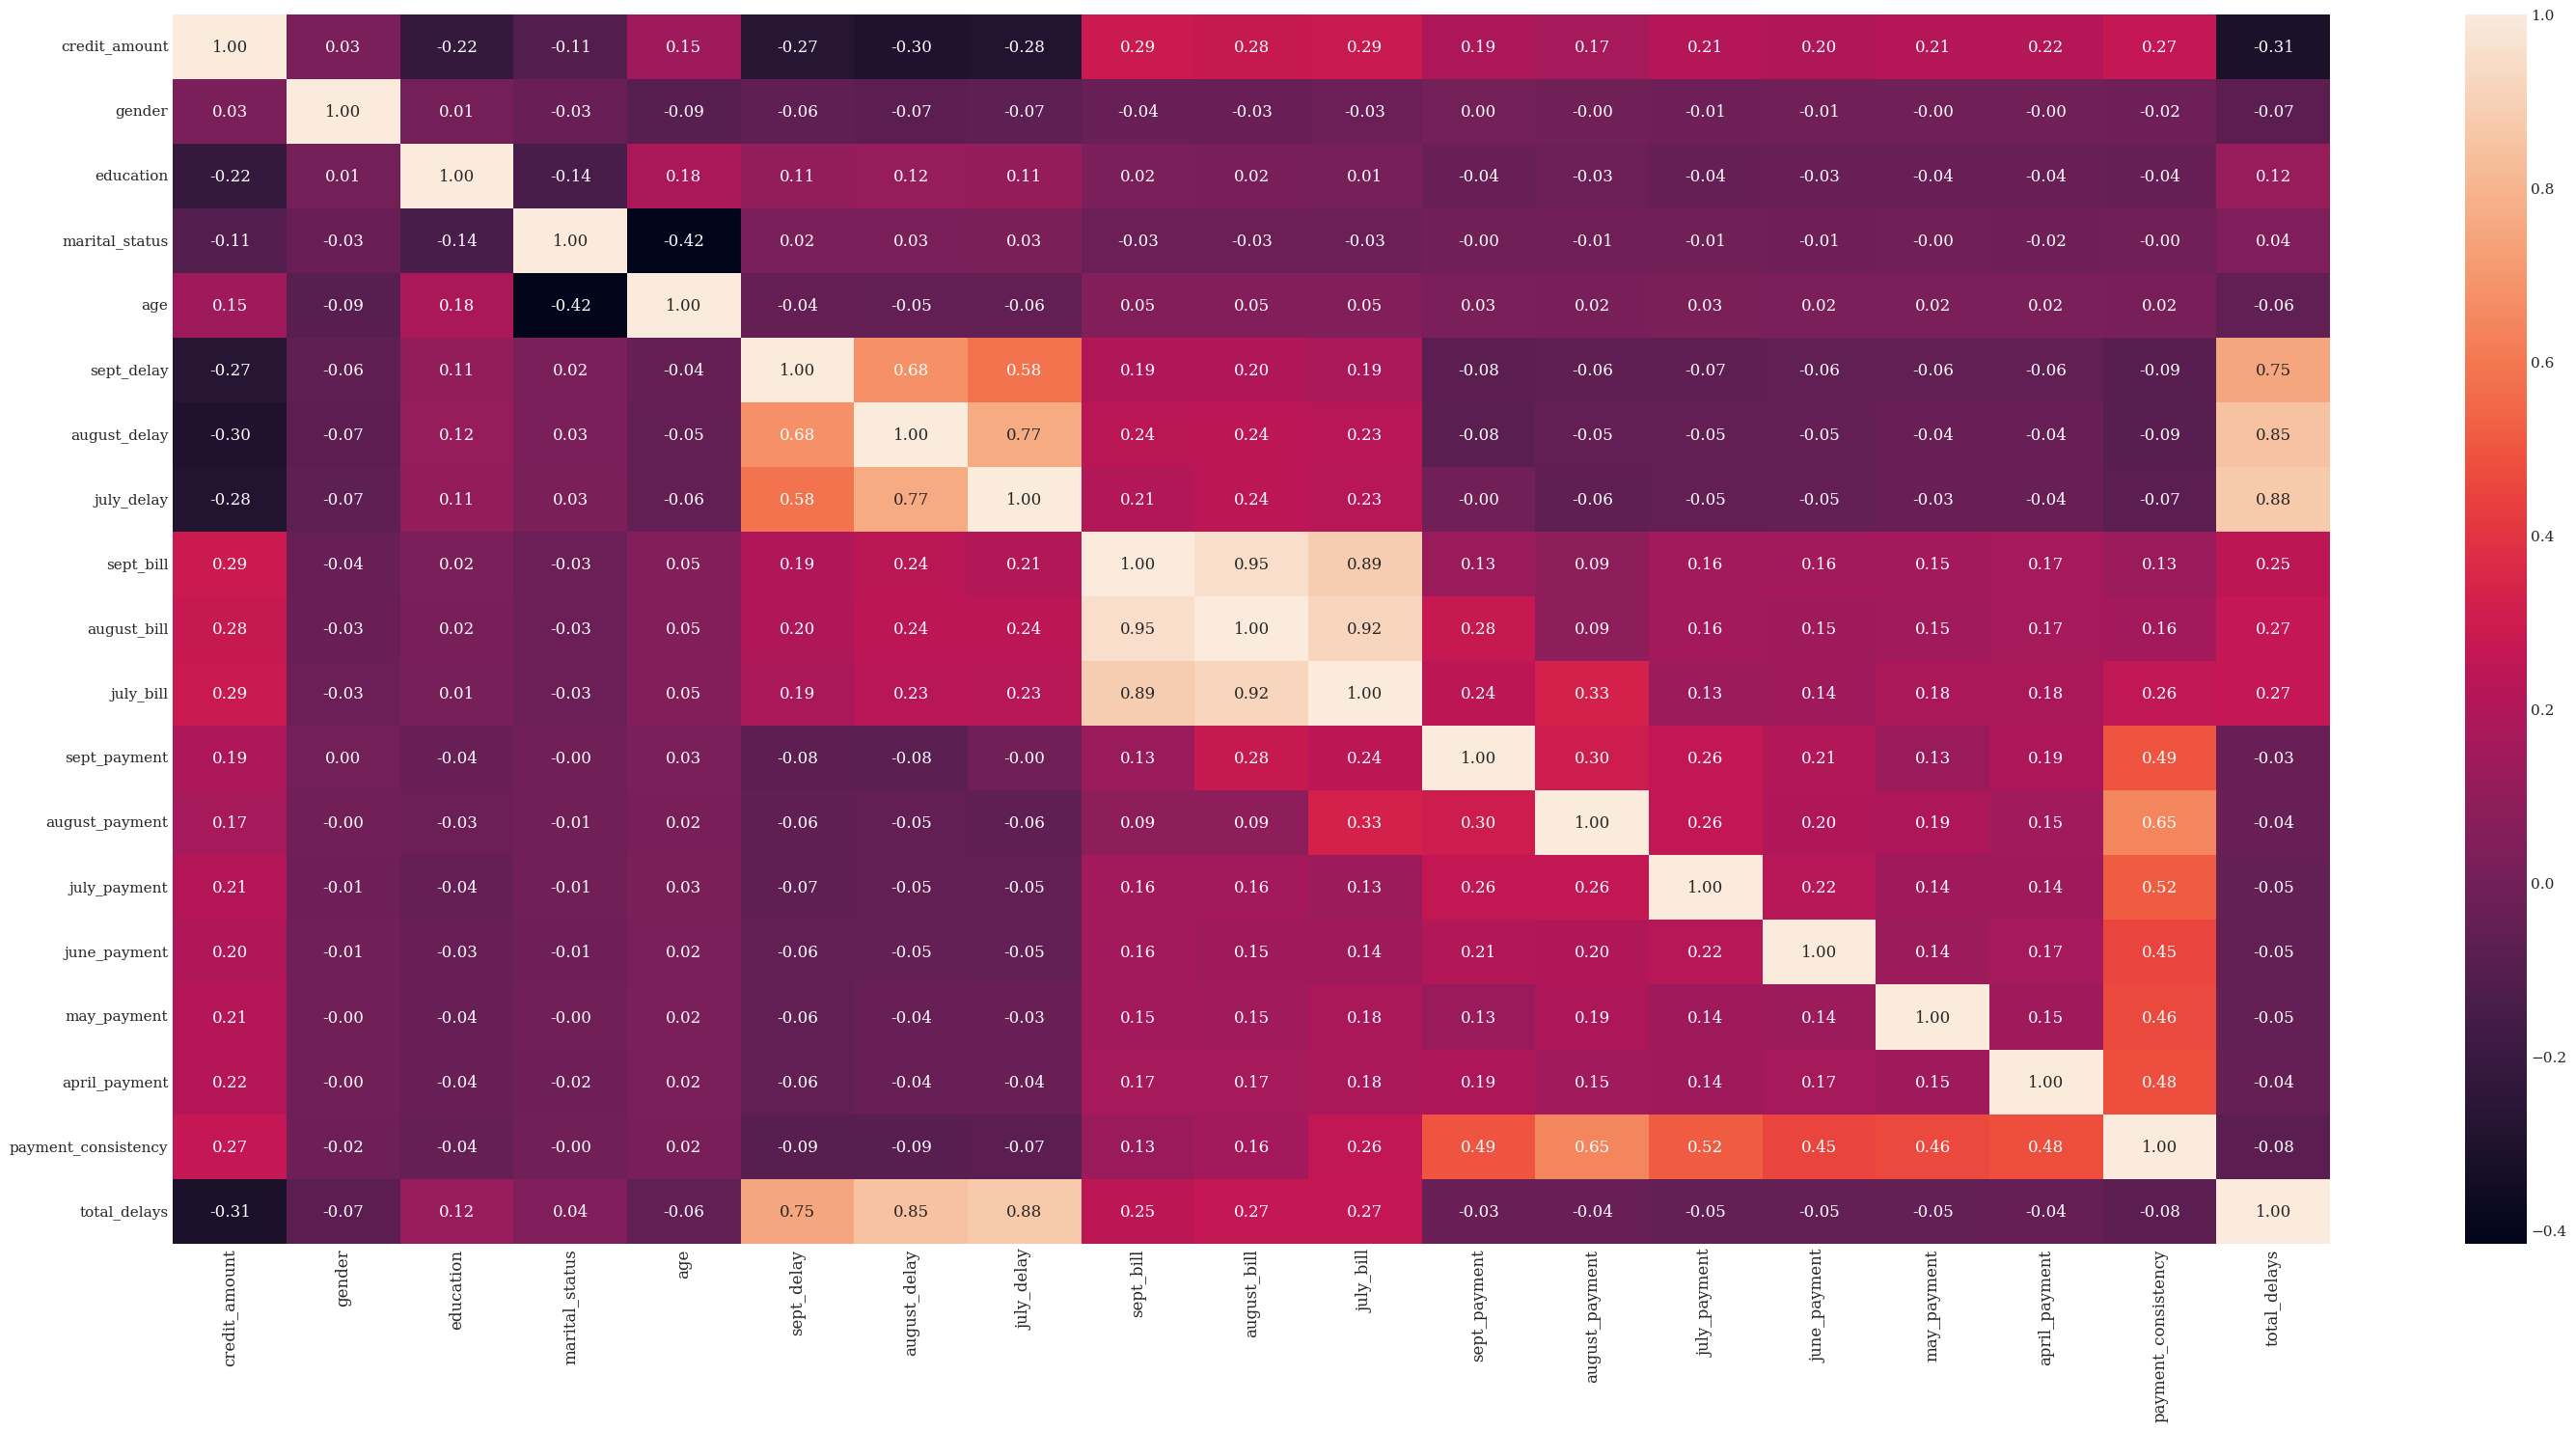

In [43]:
# This shows the distribution of the target variable in our dataset
print(y_train.value_counts(normalize= True))

# correlation analysis of Train dataset
plt.figure(figsize= (30,15))
sns.heatmap(X_train.corr(), fmt= '.2f', annot= True)
plt.tight_layout()
plt.show()

## 4. Model Selection and Training
---
- Model 1: Decision Tree
- Model 2: Logistic Regression
- Model 3: Support Vector Machines
- Model 4: K Nearest Neighbours
- Model 5: XGBoost

random_state = 70 where applicable

**Evaluation Metrics**

The evaluation metrics used to select the optimal model are
- Recall
- Precision
- F1-Score on the positive class. 

The metrics were as set to the positive class because of the propenisty of machine learning models to undeform in predicting the minority class which is the positive class (Default) in this case.



In [44]:

# split training data into stratified kfold for reproducibility

cv = StratifiedKFold(n_splits= 5,
                     shuffle= True, #splits
                     random_state= random_state)

**Utitlity Functions for Plots and Evaluation Metrics**

In [45]:
def plot_confusion_matrix(y_pred, y_true=y_train, title=None):
    """
    Parameters
    ----------
    y_pred : np.ndarray
        Prediction of the estimator/classifier.
    y_true : pd.Series, optional
        Test data values. Defaults to `y_train`.
    title : str, optional
        Title for plot. Defaults to None.

    Returns
    -------
    None
        Simply displays the confusion matrix of our classifier.
    """

    labels = ['No Default', 'Default']

    # We create a dataframe with the appropriate labels
    cm = confusion_matrix(y_true= y_true, y_pred = y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(6.5, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cbar= False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def estimator_report(y_pred, y_true=y_train, title=None):
    """
    Parameters
    ----------
    y_pred : np.ndarray
        Prediction of the estimator/classifier.
    y_true : pd.Series, optional
        Test data values. Defaults to `y_train`.
    title : str, optional
        Title for metrics that would be produced. Defaults to `None`.

    Returns
    -------
    None
        Simply prints some metrics for our classifier.
    """



    print(f"{'='*15} {title} {'='*10}")
    print(f"{'='*20} Classification Report {'='*20}")
    print(classification_report(y_true = y_true, y_pred= y_pred, target_names=['Non-Default', 'Default']))

    print((20+len(' Classification Report ')+20)*'=')
    print(f"Recall: {recall_score(y_true, y_pred):.5f}")
    print(f"Precision-Score: {precision_score(y_true, y_pred):.5f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.5f}")

    plot_confusion_matrix(y_pred,y_true, title)


# Here I will be evaluation model performance based on full training set and cross validation set.
def get_train_metrics(clf, title, X_train = X_train, y_train = y_train):
    """
    Gets the model's performance on the full training data (without CV).

    Parameters
    ----------
    clf : estimator
        sklearn estimator used for the classification. The estimator must not be fitted yet.
    title : str
        Title for metrics that would be produced.
    X_train : array-like, optional
        Training Feature Matrix. Defaults to `X_train`.
    y_train : pd.Series, optional
        Train data values. Defaults to `y_train`.
    
    Returns
    -------
    None
        Outputs classification report metrics and confusion plot.
    """

    clf.fit(X_train,y_train)
    clf_train_pred = clf.predict(X_train) 
    estimator_report(clf_train_pred,title= title)

def get_cv_metrics(clf, title,X_train = X_train, y_train = y_train):
    """
    Estimates the model's performance on unseen data using cross-validation on the training set.

    Parameters
    ----------
    clf : sklearn.estimator
        Sklearn estimator used for the classification. The estimator must not be fitted yet.
    title : str
        Title for metrics that would be produced.
    X_train : array-like, optional
        Training Feature Matrix. Defaults to `X_train`.
    y_train : pd.Series, optional
        Train data values. Defaults to `y_train`.
    Returns
    -------
    None
        Outputs classifcation report metrics and Confusion Plot.
    """
    # prediction using cross validation
    # cv = 5, we are using stratified kfold
    cv_pred = cross_val_predict(
        clf,
        X= X_train,
        y= y_train,
        cv = cv)

    # Evaluate performance
    estimator_report(cv_pred,title= title)

### 4.1 Model 1: Decision Tree
---

=============== Decision Tree (untuned, Engineered): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00     16334
     Default       1.00      1.00      1.00      4641

    accuracy                           1.00     20975
   macro avg       1.00      1.00      1.00     20975
weighted avg       1.00      1.00      1.00     20975

Recall: 0.99785
Precision-Score: 1.00000
F1-Score: 0.99892


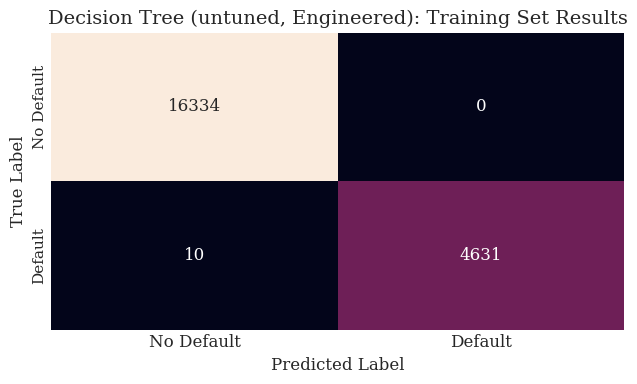

=============== Decision Tree (untuned): 5-Fold Stratified Cross-Validation Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.83      0.81      0.82     16334
     Default       0.38      0.41      0.39      4641

    accuracy                           0.72     20975
   macro avg       0.60      0.61      0.61     20975
weighted avg       0.73      0.72      0.73     20975

Recall: 0.40789
Precision-Score: 0.38104
F1-Score: 0.39401


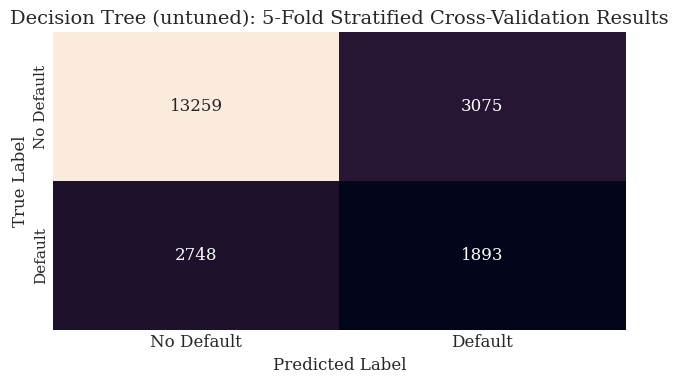

In [46]:
# init classifier
tree_clf = DecisionTreeClassifier(random_state=random_state)

# Evaluation on Engineered Train Data
get_train_metrics(clf= tree_clf,
                  title= "Decision Tree (untuned, Engineered): Training Set Results")

# Evaluation on Cross Validation Splits
get_cv_metrics(clf= tree_clf,
                  title= "Decision Tree (untuned): 5-Fold Stratified Cross-Validation Results"
                  )

=============== Decision Tree (untuned, Raw): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00     16334
     Default       1.00      1.00      1.00      4641

    accuracy                           1.00     20975
   macro avg       1.00      1.00      1.00     20975
weighted avg       1.00      1.00      1.00     20975

Recall: 0.99785
Precision-Score: 1.00000
F1-Score: 0.99892


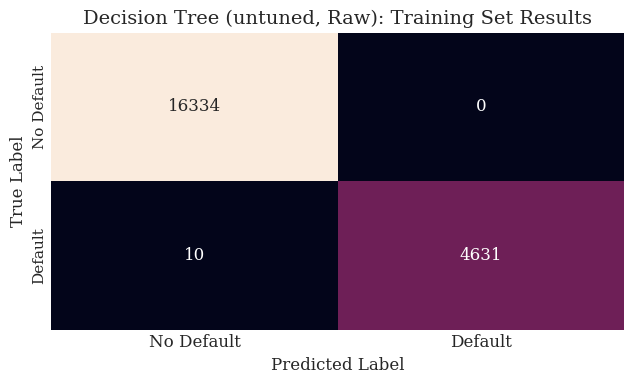

=============== Decision Tree (untuned, raw): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.81      0.82     16334
     Default       0.37      0.39      0.38      4641

    accuracy                           0.72     20975
   macro avg       0.60      0.60      0.60     20975
weighted avg       0.72      0.72      0.72     20975

Recall: 0.38979
Precision-Score: 0.37199
F1-Score: 0.38068


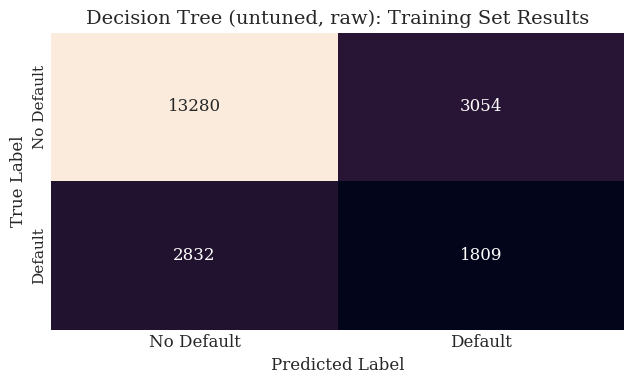

In [47]:
# Evaluation on raw Train Data
get_train_metrics(clf= tree_clf,
                  title= "Decision Tree (untuned, Raw): Training Set Results",
                  X_train=X_train_raw,
                  y_train=y_train_raw)

get_cv_metrics(clf= tree_clf,
                  title= "Decision Tree (untuned, raw): Training Set Results",
                  X_train=X_train_raw,
                  y_train=y_train_raw)

### 4.2 Model 2: Logisitic Regression
---

=============== Logistic Regression (untuned, Engineered): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89     16334
     Default       0.71      0.23      0.35      4641

    accuracy                           0.81     20975
   macro avg       0.76      0.60      0.62     20975
weighted avg       0.79      0.81      0.77     20975

Recall: 0.23034
Precision-Score: 0.71077
F1-Score: 0.34793


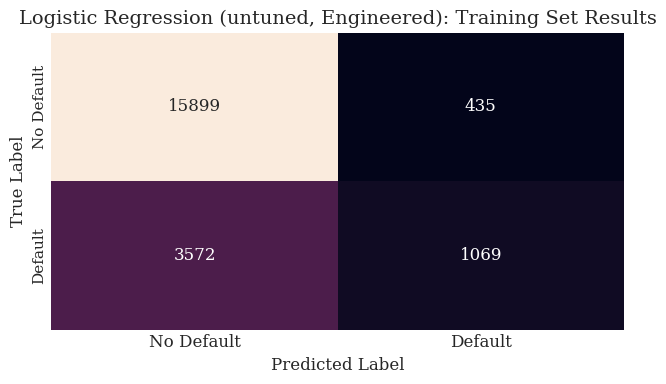

=============== Logistic Regression (untuned, Engineered): 5-Fold Stratified Cross-Validation Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89     16334
     Default       0.71      0.23      0.34      4641

    accuracy                           0.81     20975
   macro avg       0.76      0.60      0.62     20975
weighted avg       0.79      0.81      0.77     20975

Recall: 0.22775
Precision-Score: 0.70892
F1-Score: 0.34475


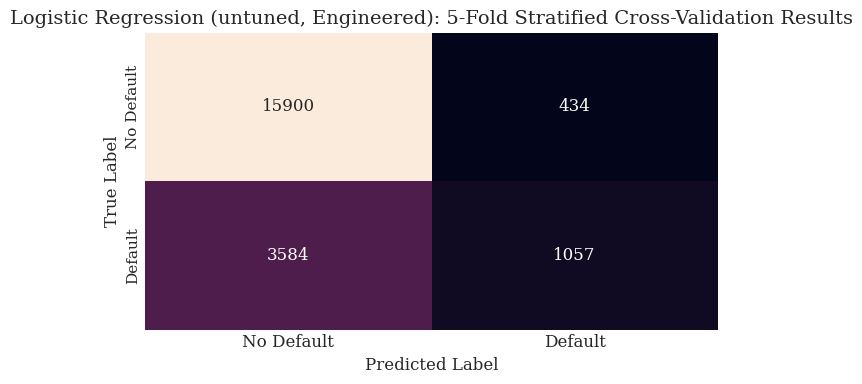

In [48]:
# init classifier
lr_clf = LogisticRegression(C= 30, random_state= random_state)


# Evaluation on Engineered Train Data
get_train_metrics(clf= lr_clf,
                  title= "Logistic Regression (untuned, Engineered): Training Set Results")

get_cv_metrics(clf= lr_clf,
                  title= "Logistic Regression (untuned, Engineered): 5-Fold Stratified Cross-Validation Results"
                  )

=============== Logistic Regression (untuned, Raw): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89     16334
     Default       0.71      0.23      0.35      4641

    accuracy                           0.81     20975
   macro avg       0.77      0.60      0.62     20975
weighted avg       0.79      0.81      0.77     20975

Recall: 0.23185
Precision-Score: 0.71495
F1-Score: 0.35015


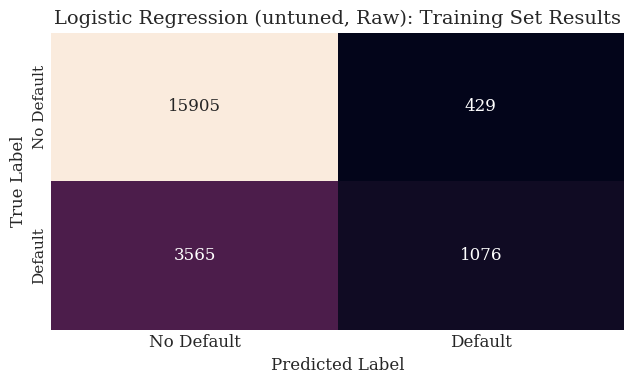

=============== Logistic Regression (untuned, Raw): CV Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89     16334
     Default       0.71      0.23      0.35      4641

    accuracy                           0.81     20975
   macro avg       0.76      0.60      0.62     20975
weighted avg       0.79      0.81      0.77     20975

Recall: 0.23120
Precision-Score: 0.71154
F1-Score: 0.34900


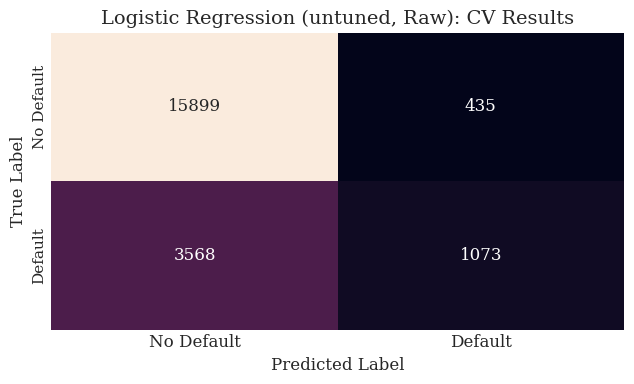

In [49]:

# Evaluation on raw Train Data
get_train_metrics(clf= lr_clf,
                  title= "Logistic Regression (untuned, Raw): Training Set Results",
                  X_train=X_train_raw,
                  y_train=y_train_raw)

get_cv_metrics(clf= lr_clf,
                  title= "Logistic Regression (untuned, Raw): CV Results",
                  X_train=X_train_raw,
                  y_train=y_train_raw)

### 4.3 Model 3: Support Vector Machines
---

In [50]:
# init classifier
svm_clf = SVC(kernel='sigmoid',
              probability= True,
              random_state=random_state)


# Evaluation on Engineered Train Data
get_train_metrics(clf= svm_clf,
                  title= "SVM (untuned, Engineered): Training Set Results")

# Evaluation on Cross Validation Splits
get_cv_metrics(clf= svm_clf,
                  title= "SVM (untuned, Engineered): 5-Fold Stratified Cross-Validation Results"
                  )


KeyboardInterrupt: 

=============== SVM (untuned, Raw): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.84      0.84      0.84     16334
     Default       0.42      0.42      0.42      4641

    accuracy                           0.75     20975
   macro avg       0.63      0.63      0.63     20975
weighted avg       0.74      0.75      0.75     20975

Recall: 0.42232
Precision-Score: 0.42406
F1-Score: 0.42319


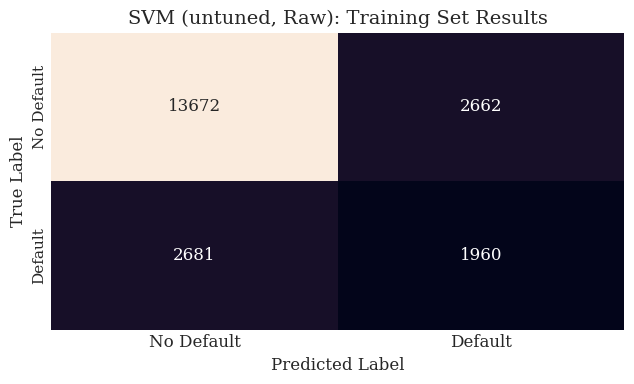

=============== SVM (untuned, raw): 5-Fold Stratified Cross-Validation Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.80      0.80      0.80     16334
     Default       0.29      0.28      0.28      4641

    accuracy                           0.69     20975
   macro avg       0.54      0.54      0.54     20975
weighted avg       0.68      0.69      0.68     20975

Recall: 0.28011
Precision-Score: 0.28540
F1-Score: 0.28273


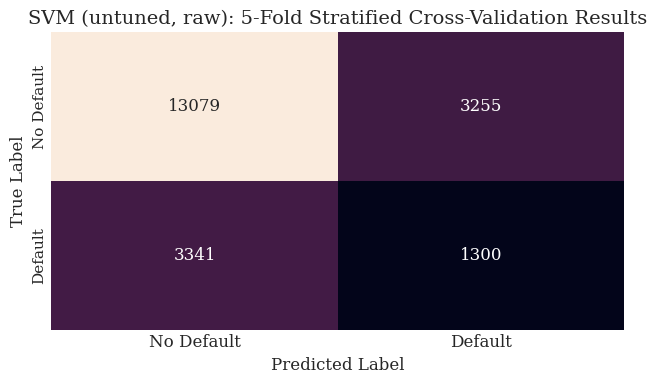

In [ ]:
# Evaluation on raw Train Data
get_train_metrics(clf= svm_clf,
                  title= "SVM (untuned, Raw): Training Set Results",
                  X_train=X_train_raw,
                  y_train=y_train_raw)

get_cv_metrics(clf= svm_clf,
                  title= "SVM (untuned, raw): 5-Fold Stratified Cross-Validation Results",
                  X_train=X_train_raw,
                  y_train=y_train_raw)

### 4.4 Model 4: K-Nearest-Neighbours
---

In [ ]:
np.sqrt(X_train.shape[0])

144.8274835796024

c:\Users\banji\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\banji\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\banji\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\banji\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\banji\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

=============== K-Nearest Neighbors (untuned, Engineered): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.83      0.95      0.89     16334
     Default       0.66      0.33      0.44      4641

    accuracy                           0.81     20975
   macro avg       0.75      0.64      0.67     20975
weighted avg       0.80      0.81      0.79     20975

Recall: 0.33333
Precision-Score: 0.66139
F1-Score: 0.44327


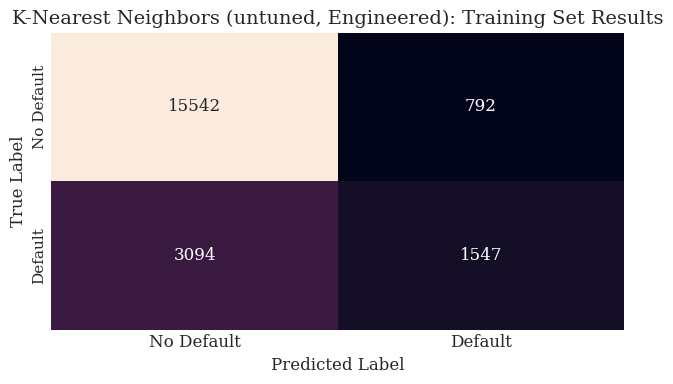

=============== K-Nearest Neighbors (untuned, Engineered): 5-Fold Stratified Cross-Validation Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.83      0.95      0.89     16334
     Default       0.66      0.33      0.44      4641

    accuracy                           0.81     20975
   macro avg       0.75      0.64      0.67     20975
weighted avg       0.80      0.81      0.79     20975

Recall: 0.33183
Precision-Score: 0.65925
F1-Score: 0.44145


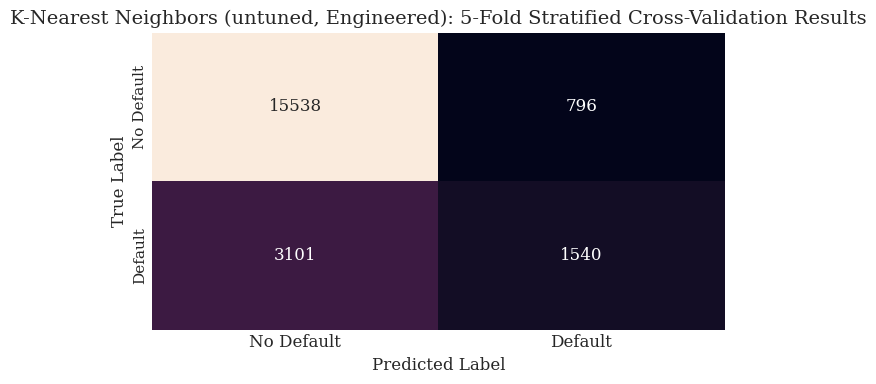

In [ ]:
# init classifier
knn_clf = KNeighborsClassifier(n_neighbors= 145)

# Evaluation on Engineered Train Data
get_train_metrics(
    clf= knn_clf,
    title= "K-Nearest Neighbors (untuned, Engineered): Training Set Results"
    )

get_cv_metrics(
    clf= knn_clf,
    title= "K-Nearest Neighbors (untuned, Engineered): 5-Fold Stratified Cross-Validation Results"
    )


=============== K-Nearest Neighbors (untuned, Raw): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.83      0.96      0.89     16334
     Default       0.67      0.29      0.41      4641

    accuracy                           0.81     20975
   macro avg       0.75      0.62      0.65     20975
weighted avg       0.79      0.81      0.78     20975

Recall: 0.29002
Precision-Score: 0.67199
F1-Score: 0.40518


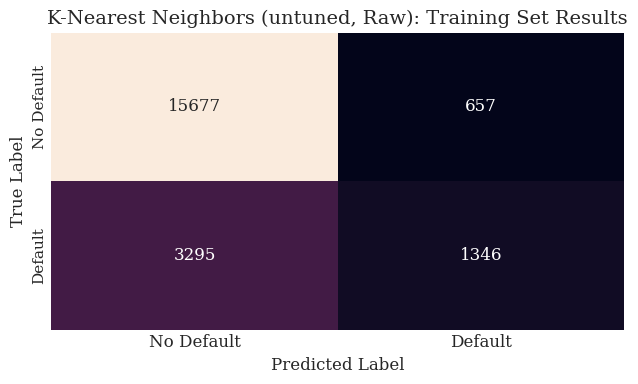

=============== K-Nearest Neighbors (untuned, raw): 5-Fold Stratified Cross-Validation Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.82      0.96      0.89     16334
     Default       0.66      0.27      0.39      4641

    accuracy                           0.81     20975
   macro avg       0.74      0.62      0.64     20975
weighted avg       0.79      0.81      0.78     20975

Recall: 0.27300
Precision-Score: 0.66266
F1-Score: 0.38669


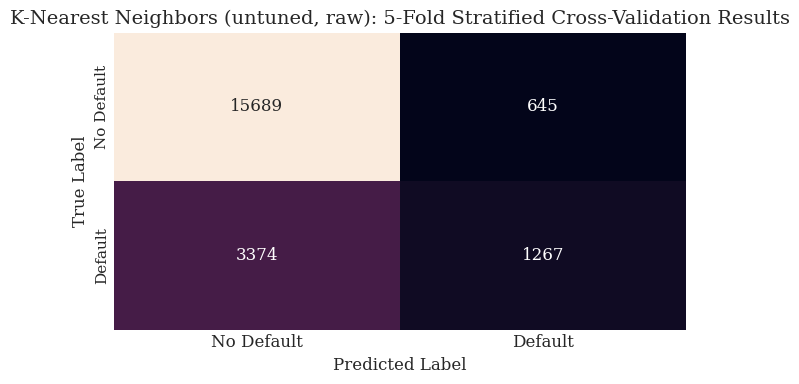

In [ ]:
# Evaluation on raw Train Data
get_train_metrics(
    clf= knn_clf,
    title= "K-Nearest Neighbors (untuned, Raw): Training Set Results",
    X_train=X_train_raw,
    y_train=y_train_raw
    )

get_cv_metrics(
    clf= knn_clf,
    title= "K-Nearest Neighbors (untuned, raw): 5-Fold Stratified Cross-Validation Results",
    X_train=X_train_raw,
    y_train=y_train_raw
    )

### 4.5 Model 5: XGBoost
---

In [ ]:
# init classifier
xgb_clf = XGBClassifier()


=============== XGBoost (untuned, Engineered): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.89      0.98      0.93     16334
     Default       0.91      0.58      0.70      4641

    accuracy                           0.89     20975
   macro avg       0.90      0.78      0.82     20975
weighted avg       0.89      0.89      0.88     20975

Recall: 0.57638
Precision-Score: 0.90586
F1-Score: 0.70450


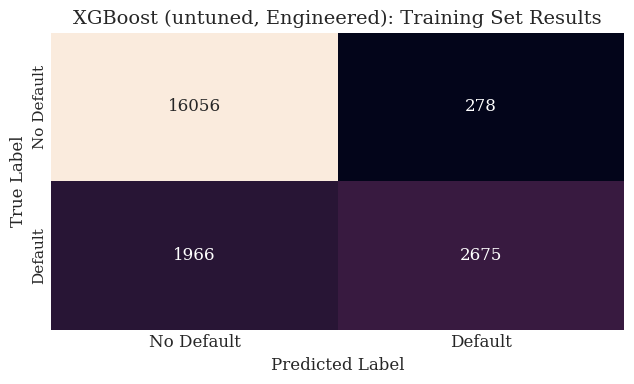

=============== XGBoost(untuned, Engineered): 5-Fold Stratified Cross-Validation Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.84      0.94      0.88     16334
     Default       0.62      0.35      0.45      4641

    accuracy                           0.81     20975
   macro avg       0.73      0.64      0.67     20975
weighted avg       0.79      0.81      0.79     20975

Recall: 0.34992
Precision-Score: 0.62366
F1-Score: 0.44831


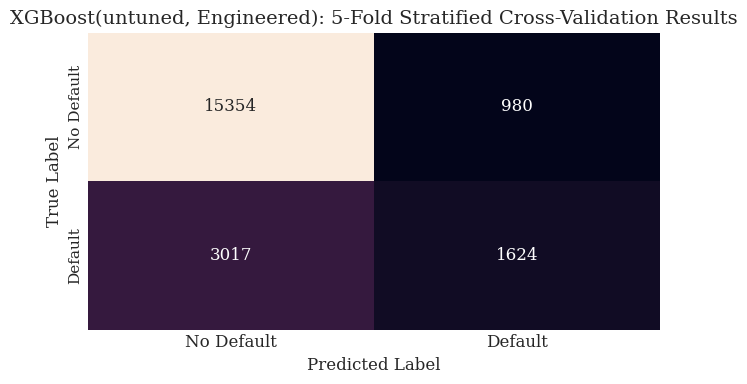

In [ ]:
# Evaluation on Engineered Train Data
get_train_metrics(
    clf= xgb_clf,
    title= "XGBoost (untuned, Engineered): Training Set Results"
    )

# Evaluation on Cross Validation Splits
get_cv_metrics(
    clf= xgb_clf,
    title= "XGBoost(untuned, Engineered): 5-Fold Stratified Cross-Validation Results"
                  )


=============== XGBoost (untuned, Raw): Training Set Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.89      0.98      0.93     16334
     Default       0.91      0.57      0.70      4641

    accuracy                           0.89     20975
   macro avg       0.90      0.78      0.82     20975
weighted avg       0.89      0.89      0.88     20975

Recall: 0.56841
Precision-Score: 0.90809
F1-Score: 0.69918


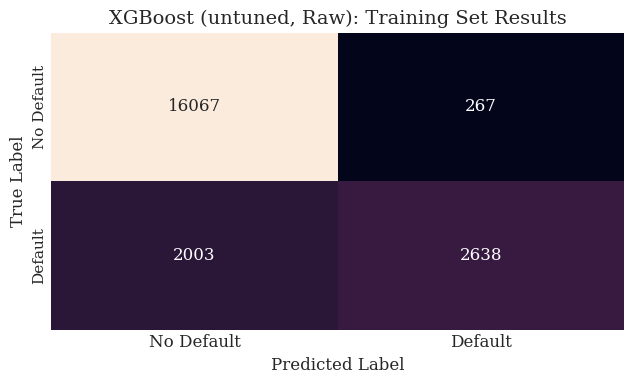

=============== XGBoost (untuned, raw): 5-Fold Stratified Cross-Validation Results ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.84      0.94      0.88     16334
     Default       0.62      0.35      0.45      4641

    accuracy                           0.81     20975
   macro avg       0.73      0.64      0.67     20975
weighted avg       0.79      0.81      0.79     20975

Recall: 0.34712
Precision-Score: 0.62177
F1-Score: 0.44552


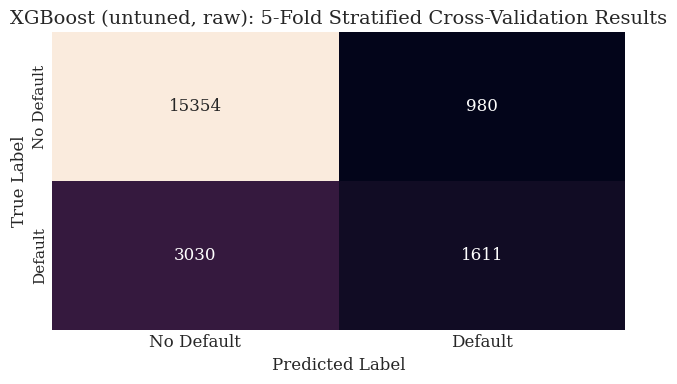

In [ ]:

# Evaluation on raw Train Data
get_train_metrics(
    clf= xgb_clf,
    title= "XGBoost (untuned, Raw): Training Set Results",
    X_train=X_train_raw,
    y_train=y_train_raw
    )

get_cv_metrics(
    clf= xgb_clf,
    title= "XGBoost (untuned, raw): 5-Fold Stratified Cross-Validation Results",
    X_train=X_train_raw,
    y_train=y_train_raw
                  )

In [ ]:
# This is specifically used for the getting of evaluation metrics for our models
# which will be used to plot the grouped bar chart for the report.

def get_metric(clf, X_true=X_train, y_true=y_train, cross_val = False, cv = cv):

    """
    Gets the recall, precision, and f1_score for classifier's using training data or cross-validation set.
 
    Parameters
    ----------
    clf : estimator object
       Already fitted Scikitlear/XGBoost Estimator. 

    X_true : array-like, optional
        Feature matrix to train or evaluate the classifier. Defaults to `X_train`.

    y_true : array-like, optional
        Target labels corresponding to `X_true`. Defaults to `y_train`.

    cross_val : bool, optional, default=False
        Whether to perform cross-validation. If True, uses `cross_val_score`.

    cv : StratifiedKfold, optional
        Should be defined globally before passing into the function. 
        Comes into play ` if `cross_val=True`. Passed to `cross_val_score. Defaults to `cv`.

    Returns
    -------
    tuple
        A tuple containing
        Recall: float
            The recall score of the positive class of the classifier if `cross_val=False`, or the mean
            cross-validation score if `cross_val=True`.
        
        Precision: float
            The precision score of the positive class of the classifier if `cross_val=False`, or the mean
            cross-validation score if `cross_val=True`.

        f1_score: float
            The precision score of the positive class of the classifier if `cross_val=False`, 
            or the mean cross-validation score if `cross_val=True`.
    """


    if cross_val is False:
        clf.fit(X_true,y_true)
        y_pred =  clf.predict(X_true)
    elif cross_val is True:
        y_pred = cross_val_predict(clf,
                                X= X_true,
                                y=y_true,
                                cv = cv)
    else:
        return "Invalid cross_val response"
    
    recall = recall_score(y_true,y_pred, pos_label = 1)
    precision = precision_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label= 1)
    return recall, precision, f1

In [ ]:
# model_name and model for metrics.
model_name = [
    'XGBoost',
    'Support Vector Machines',
    'Logistic Regression',
    'Decision Tree',
    'K-Nearest Neighbors'
    ]

models = [
    xgb_clf,
    svm_clf,
    lr_clf,
    tree_clf,
    knn_clf
    ]

### 4.6 Trainset (untuned) Metrics

In [ ]:
# I need to do for the train and then for the validation splits
recall_result = []
precision_result = []
f1_result = []
for model in models:
    metric = get_metric(model, cross_val = False) # on train_set
    recall_result.append(metric[0])
    precision_result.append(metric[1])
    f1_result.append(metric[2])

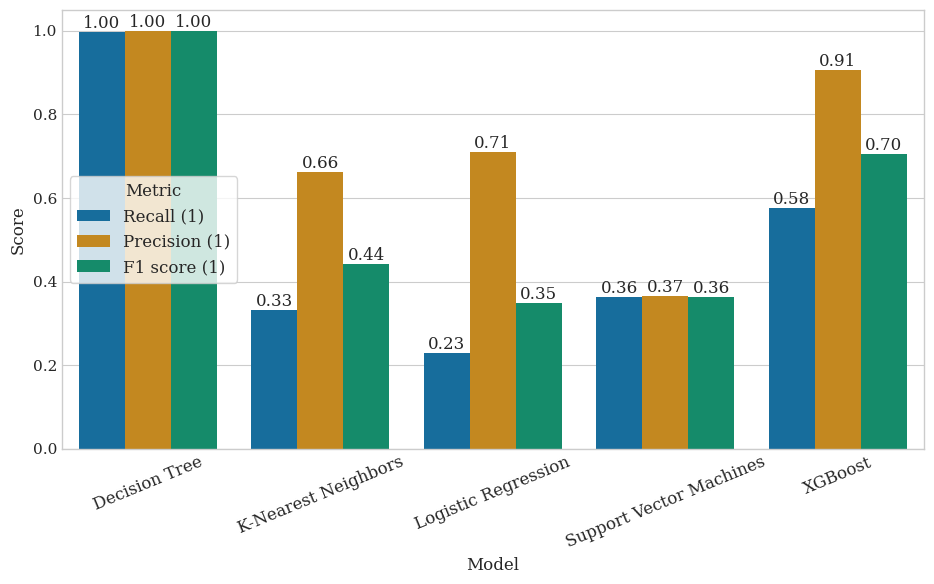

In [ ]:
result_before_tuning_train = pd.DataFrame({
    'Models': model_name,
    'Recall (1)':recall_result,
    "Precision (1)" : precision_result, 
    "F1 score (1)" : f1_result
    })
result_before_tuning_train.sort_values(by= 'Models', inplace = True)

# We need to reshape the DataFrame into a  long format for grouped bar chart
df_untuned_train = pd.melt(
    result_before_tuning_train,
    id_vars='Models', # type: ignore
    value_vars=['Recall (1)', 'Precision (1)',"F1 score (1)"],
    var_name='Metric',
    value_name='Score'
    )

# Plot grouped bar chart
plt.figure(figsize=(9.5, 6))
ax = sns.barplot(data=df_untuned_train, x='Models', y='Score', hue='Metric')

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

#plt.title("Training set metrics before hyperparameter tuning (RandomizedSearchCV)")
plt.xticks(rotation=22.5)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric', frameon = True, loc = 'center left')
plt.tight_layout()
plt.savefig('Training set metrics before hyperparameter tuning (RandomizedSearchCV).png', 
           dpi=300, 
           bbox_inches='tight',    
           pad_inches=0.1,         
           facecolor='white') 
plt.show()

### 4.7 Cross Validation Split (Untuned) metrics

In [ ]:
# I need to do for the train and then for the validation splits
recall_result = []
precision_result = []
f1_result = []
for model in models:
    metric = get_metric(model, cross_val = True) # cross_val = True
    recall_result.append(metric[0])
    precision_result.append(metric[1])
    f1_result.append(metric[2])

In [ ]:
result_before_tuning_cv = pd.DataFrame({
    'Models': model_name,
    'Recall (1)':recall_result,
    "Precision (1)" : precision_result, 
    "F1 score (1)" : f1_result
    })
result_before_tuning_cv.sort_values(by= 'Models', inplace = True)

# reshaped to long format
df_untuned_cv = pd.melt(
    result_before_tuning_cv,
    id_vars='Models',
    value_vars=['Recall (1)', 'Precision (1)',"F1 score (1)"],
    var_name='Metric',
    value_name='Score'
)

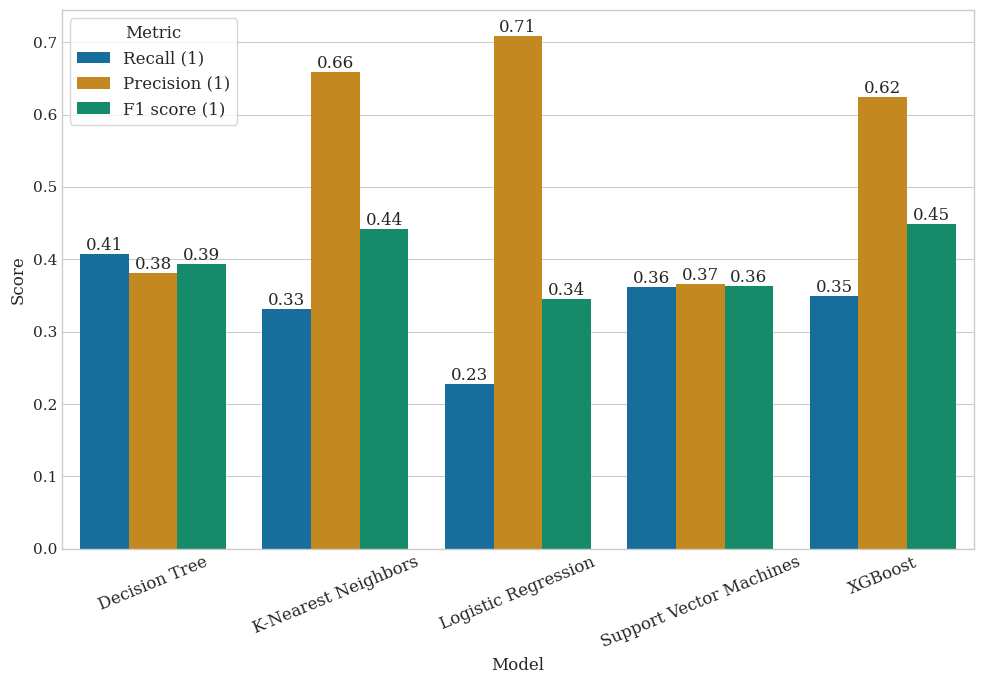

In [ ]:
# Plot grouped bar chart
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_untuned_cv, x='Models', y='Score', hue='Metric')

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

#plt.title("Cross-Validation set metrics before hyperparameter tuning (RandomizedSearchCV)")
plt.xticks(rotation=22.5)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric', frameon = True, loc = 'upper left')
plt.tight_layout()
plt.savefig("Cross-Validation set metrics before hyperparameter tuning (RandomizedSearchCV).png",
           dpi=300, 
           bbox_inches='tight',    # Removes excess whitespace
           pad_inches=0.1,         # Small padding around figure
           facecolor='white')
plt.show()


## 5. **Hyperparameter Tuning and Class Imbalance using SMOTE**

---
The finetuning of our model primarily involves selecting optimal hyperparameters for our model. So we shall be tuning the  parameters of the models using `RandomisedSearchCV`. The randomised search randomly samples combinations from a list of parameter values which have been passed in a parameter distribution and then runs for a number of iteration. After the iteration, the parameters which lead to the highest performance is selected for a model.

In the configuration here, we used an imblean pipeline object to Automatically resample the training fold and handle the class imbalance issue.

In [ ]:
def tune_params(clf,
               param_dist,
               n_iter=30,
               random_state=random_state,
               scoring={
                  'precision': 'precision',
                  'recall': 'recall',
                  'f1': 'f1',
                  'pr_auc': 'average_precision'
              }):
   
    """
    Perform hyperparameter tuning using RandomizedSearchCV with multiple scoring metrics.

    This function uses randomized search to find optimal hyperparameters for a classifier
    by evaluating multiple scoring metrics and selecting the best parameters based on F1 score.

    Parameters
    ----------
    clf : estimator/pipeline object
        The classifier to tune (e.g., RandomForestClassifier, SVC, etc.)
    param_dist : dict
        Dictionary with parameter names as keys and distributions
        or lists of parameter settings to try as values
    n_iter : int, optional
        Number of parameter settings sampled from param_dist.
        Defaults to 30.
    random_state : int
        Random state for reproducible results
    scoring : dict, optional
        Dictionary of scoring metrics to evaluate during
        cross-validation. Defaults to precision, recall, f1, and pr_auc.
       
    Returns
    -------
    tuple
       A tuple containing:
       - best_clf: The best estimator found by the search, fitted on training data
       - training time (flaot): Time taken to complete training process (in seconds)
       - duration (float): Time taken to complete tuning process (in seconds)
       - random_search object.
    """
    
    random_search = RandomizedSearchCV(estimator = clf,
                                       param_distributions = param_dist,
                                       n_iter = n_iter,
                                       cv = cv, #stratified k fold has been defined earlier
                                       scoring = scoring,
                                       refit='f1', # This is the overall parameter we are trying to optimise
                                       n_jobs= -1, # I opted to use all of my CPU's 8 cores as the SVM experiment lasted 6 hrs+
                                       verbose= 2, # This shows some progress of the cv search 
                                       random_state = random_state)
    
    # Tuning Time
    start_tune = time.time()
    random_search.fit(X_train,y_train)
    stop_tune = time.time()
    tuning_time = stop_tune - start_tune

    
    # Best estimator
    best_clf = random_search.best_estimator_

    # training time
    start = time.time()
    best_clf.fit(X_train, y_train)
    training_time = time.time() - start
    
    return best_clf, tuning_time, training_time, random_search

### 5.1 Model 1: Decision Tree
---

In [ ]:
# Create pipeline that handles resampling automatically
tree_pipeline = Pipeline([
    ('smote', SMOTE(random_state=random_state)),
    ('tree', tree_clf)
])

# Define Parameter Distribution
tree_param_dist = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [3, 5, 7, 10, 15],
    'tree__min_samples_split': [20, 50, 100, 200], 
    'tree__min_samples_leaf': [10, 20, 50, 100],   
    'tree__max_features': ['sqrt', 'log2', 0.5],
    'tree__max_leaf_nodes': [50, 100, 200, 500] 
}

In [ ]:
# Run randomised search
tree_random_search = tune_params(clf= tree_pipeline,
                                  param_dist= tree_param_dist
                                  )

# Best Tree clf with tuned parameters
tree_best_clf = tree_random_search[0]
tree_tuning_duration = tree_random_search[1]
tree_training_duration = tree_random_search[2]

print(f"training time {tree_training_duration}\ntuning time {tree_tuning_duration}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
training time 0.2162463665008545
tuning time 19.13260293006897


### 5.2 Model 2: Logisitic Regression
---


In [ ]:
# Create pipeline that handles resampling automatically
lr_pipeline = Pipeline([
    ('smote', SMOTE(random_state=random_state)),
    ('lr', lr_clf)
])

lr_param_dist = {
    'lr__C': loguniform(0.01, 100),           # Wider, log scale
    'lr__class_weight': [None, 'balanced'],  
    'lr__max_iter': randint(100, 2000),     # I thoughr I had to set random state her but the rndom state set in the RandomisedSearchCV is enough  
    'lr__solver': ['liblinear', 'lbfgs'],     # Different optimization algorithms
    'lr__penalty': ['l1', 'l2']               # L1 for feature selection, L2 for regularization
}

In [ ]:
# Run randomised search
lr_random_search = tune_params(clf= lr_pipeline,
                               param_dist= lr_param_dist)
# get duration
lr_tuning_duration = lr_random_search[1]
lr_training_duration = lr_random_search[2]

print(f"training time {lr_training_duration}\ntuning time {lr_tuning_duration}")
# Best log reg clf with tuned parameters
lr_best_clf = lr_random_search[0]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\banji\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\banji\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\banji\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\banji\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 333, in fit
    self._final_estimator.f

training time 0.6717731952667236
tuning time 25.875393390655518


### 5.3 Model 3: Support Vector Machines
---

In [ ]:
# Create pipeline that handles resampling automatically
svm_pipeline = Pipeline([
    ('smote', SMOTE(random_state=random_state)),
    ('svm', svm_clf)
])


'''svm_param_dist = {
    'svm__C': np.logspace(-2, 2, 15),  
    'svm__kernel': ['linear', 'rbf'],  
    'svm__gamma': ['scale'] + list(np.logspace(-3, 0, 5)),
    'svm__class_weight': [None, 'balanced']
}
'''
# The above was cancelled because it was too expensice
svm_param_dist = {
    'svm__C': [0.1, 1, 10],  # 3 values instead of 15
    'svm__kernel': ['rbf', 'sigmoid'],  # drop 'linear' if you're focusing on non-linear
    'svm__gamma': ['scale', 0.1],  # fewer gamma values
    'svm__class_weight': [None, 'balanced']  # keep both if unsure
}

In [ ]:
# Run randomised search
svm_random_search = tune_params(clf= svm_pipeline,
                               param_dist= svm_param_dist,
                               n_iter= 12)

# Best SVM clf with tuned parameters
svm_best_clf = svm_random_search[0]

# get duration
svm_tuning_duration = svm_random_search[1]
svm_training_duration = svm_random_search[2]
print(f"training time {svm_training_duration}\ntuning time {svm_tuning_duration}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
training time 442.7053451538086
tuning time 6938.836649894714


### 5.4 Model 4: K-Nearest-Neighbours
---


In [ ]:
knn_pipeline = Pipeline([
    ('smote', SMOTE(random_state=random_state)),
    ('knn', knn_clf)
])

knn_param_dist= {
    #ball tree: better for medium dimensional data.
    #brute: search all training points and is good for high dimensional data
    'knn__algorithm': ['auto', 'ball_tree', 'brute'], 
    'knn__metric': ['minkowski', 'euclidean'],     
    'knn__n_neighbors': [5, 11, 25,77, 181, 201],
    'knn__weights': ['uniform', 'distance']
    }

In [ ]:
knn_random_search = tune_params(clf= knn_pipeline,
                                param_dist= knn_param_dist)
# Best knn clf with tuned parameters
knn_best_clf = knn_random_search[0]

# get duration
knn_tuning_duration = knn_random_search[1]
knn_training_duration = knn_random_search[2]
print(f"training time {knn_training_duration}\ntuning time {knn_tuning_duration}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
training time 0.13896894454956055
tuning time 374.27567958831787


### 5.5 Model 5: XGBoost
---

In [ ]:
# Create pipeline that handles resampling automatically
xgb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=random_state)),
    ('xgb', xgb_clf)
    ])

xgb_param_dist = {
    'xgb__n_estimators': randint(50, 200), # total number of trees, smaller is better for precenting overfitting
    'xgb__max_depth': randint(3, 10), # reduces model's complexity
    'xgb__min_child_weight': randint(1, 10), # reduces model's complexity
    'xgb__learning_rate': loguniform(0.01, 0.3),
    'xgb__reg_alpha': loguniform(0.01, 10),        # L1 regularization
    'xgb__reg_lambda': loguniform(0.01, 10)      # L2 regularization
    }

In [ ]:
xgb_random_search = tune_params(clf= xgb_pipeline,
                                param_dist= xgb_param_dist)

# Best xgb clf with tuned parameters
xgb_best_clf = xgb_random_search[0]

# get duration
xgb_tuning_duration = xgb_random_search[1]
xgb_training_duration = xgb_random_search[2]
print(f"training time {xgb_training_duration}\n tuning time {xgb_tuning_duration}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
training time 0.5818238258361816
 tuning time 47.857274770736694


In [ ]:
'''
# Let's save the objects containing all the pipeline processes and model
joblib.dump(xgb_random_search,"xgb_random_search.joblib")
joblib.dump(svm_random_search,"svm_random_search.joblib")
joblib.dump(lr_random_search,"lr_random_search.joblib")
joblib.dump(tree_random_search,"tree_random_search.joblib")
joblib.dump(knn_random_search,"knn_random_search.joblib")
'''
pass

## 6. Selection of Best Models and Evaluation Metrics
---
*Evaluation Metrics*
- F1-score
- ROC-AUC
- Confusion Matrix

### 6.1. Overview of Classifiers
---

### 6.1.1 Evaluation Metrics on Training Set
---

In [ ]:
tuned_models = [
    xgb_best_clf,
    svm_best_clf,
    lr_best_clf,
    tree_best_clf,
    knn_best_clf
    ]

In [ ]:
recall_result = []
precision_result = []
f1_result = []
for model in tuned_models:
    metric = get_metric(model, cross_val = False) # cross_val = False means the training set
    recall_result.append(metric[0])
    precision_result.append(metric[1])
    f1_result.append(metric[2])

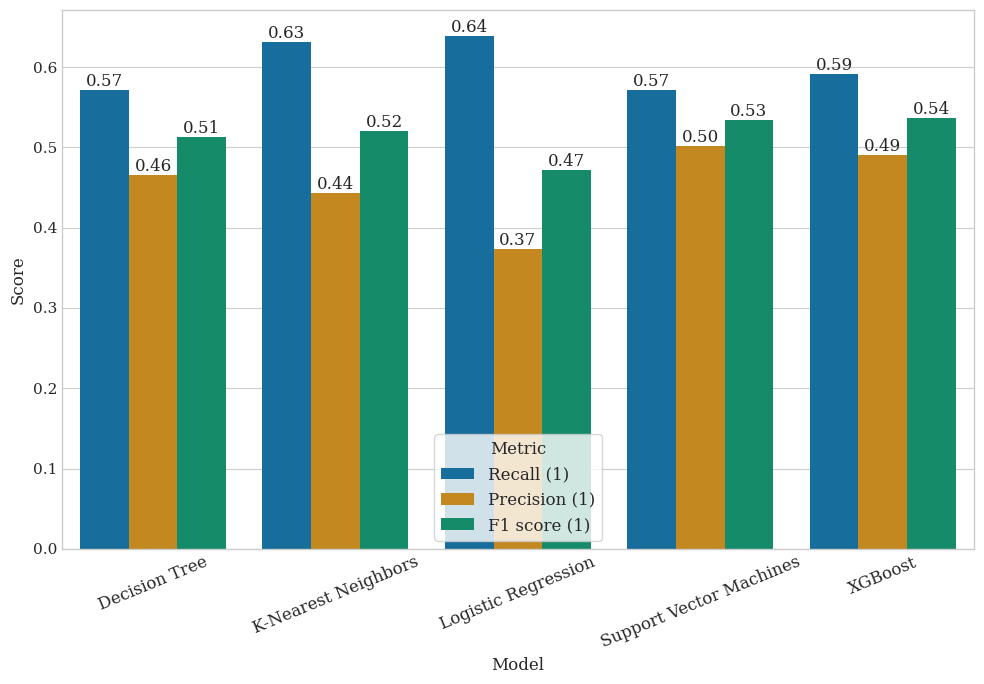

In [ ]:
# result after hyperparameter tuning
result_after_tuning_train = pd.DataFrame({
    'Models': model_name,
    'Recall (1)':recall_result, # The metric I am using is recall for positive class
    "Precision (1)" : precision_result,
    "F1 score (1)" : f1_result
    })
result_after_tuning_train.sort_values(by= 'Models', inplace = True)

# Reshape the DataFrame to long format for grouped bar chart
df_tuned_train = pd.melt(
    result_after_tuning_train,
    id_vars='Models',
    value_vars=['Recall (1)', 'Precision (1)',"F1 score (1)"],
    var_name='Metric',
    value_name='Score'
    )

# Plot grouped bar chart
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_tuned_train, x='Models', y='Score', hue='Metric')

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

#plt.title("Evaluation Metrics on Training Set After Tuning (RandomisedSearchCV)")
plt.xticks(rotation=22.5)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric', frameon = True, loc = 'lower center')
plt.tight_layout()
  
plt.show()

#### 6.1.2. Evaluation Metrics on Cross Validation Splits
---

In [ ]:
# I need to do for the train and then for the validation splits
recall_result = []
precision_result = []
f1_result = []
for model in tuned_models:
    metric = get_metric(model, cross_val = True) # cross_val = True means cv split
    recall_result.append(metric[0])
    precision_result.append(metric[1])
    f1_result.append(metric[2])

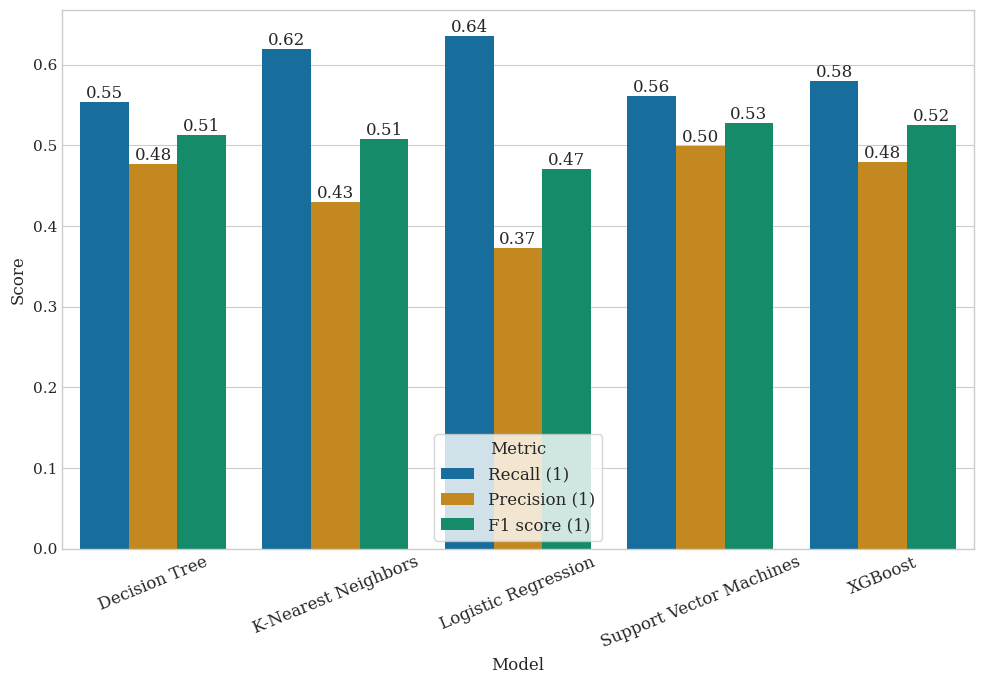

In [ ]:
# result after hyperparameter tuning
result_after_tuning_cv = pd.DataFrame({
    'Models': model_name,
    'Recall (1)':recall_result, # The metric I am using is recall for positive class
    "Precision (1)" : precision_result,
    "F1 score (1)" : f1_result
    })
result_after_tuning_cv.sort_values(by= 'Models', inplace = True)

# Reshape the DataFrame to long format for grouped bar chart
df_tuned_cv = pd.melt(
    result_after_tuning_cv,
    id_vars='Models',
    value_vars=['Recall (1)', 'Precision (1)',"F1 score (1)"],
    var_name='Metric',
    value_name='Score'
)

# Plot grouped bar chart
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=df_tuned_cv, x='Models', y='Score', hue='Metric')

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

#plt.title("Evaluation Metrics on Cross Valididation Splits After Tuning (RandomisedSearchCV)")
plt.xticks(rotation=22.5)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric', frameon = True, loc = 'lower center')
plt.tight_layout()
plt.savefig('Evaluation Metrics on Cross Valididation Splits After Tuning (RandomisedSearchCV).png', 
           dpi=300, 
           bbox_inches='tight',
           pad_inches=0.1,        
           facecolor='white')     
plt.show()

In [ ]:
# not used in main report
def plot_pr_auc(clf, model_name="Model", save = False):
   """
   Plot Precision-Recall curve and calculate PR-AUC using cross-validation predictions.
   
   Parameters
   ----------
   clf : estimator
       The classifier to evaluate
   model_name : str, optional
       Name of the model for display purposes. Default is "Model".
       
   Returns
   -------
   float
       PR-AUC score
   """
   # Get probabilities for class 1 (Defaulters)
   y_scores = cross_val_predict(clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]
   precision, recall, tholds = precision_recall_curve(y_train, y_scores)
   pr_auc = average_precision_score(y_train, y_scores)
   
   # Plot the PR curve
   plt.figure(figsize=(6, 4))
   plt.plot(recall, precision, label=f"{model_name} (PR-AUC = {pr_auc:.3f})", color='blue', linewidth=2)
   plt.axhline(y=y_train.mean(), linestyle='--', color='gray', label='Random Classifier')
   plt.xlabel( "Recall")
   plt.ylabel( "Precision")
   plt.title(f"Precision-Recall Curve - {model_name}")
   plt.legend( frameon=True)
   plt.grid(True, alpha=0.3)
   plt.tight_layout()
   if save:
    plt.savefig(model_name +" pr-auc", 
            dpi=300, 
            bbox_inches='tight',
            pad_inches=0.1,        
            facecolor='white')     
   plt.show()
   
   print(f"{model_name} PR-AUC: {pr_auc:.3f}")
   return pr_auc

In [ ]:
def plot_auc(clf, model_name="Model", save= False):
    # Get probabilities for class 1 (Defaulters)
    y_scores = cross_val_predict(clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, tholds = roc_curve(y_train, y_scores)

    # Compute AUC
    auc = roc_auc_score(y_train, y_scores)
    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})", color='blue', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(frameon=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save:
        plt.savefig(model_name +" auc", 
                dpi=300, 
                bbox_inches='tight',
                pad_inches=0.1,        
                facecolor='white')     
    plt.show()
    
    print(f"{model_name} AUC-ROC: {auc:.3f}")
    return auc

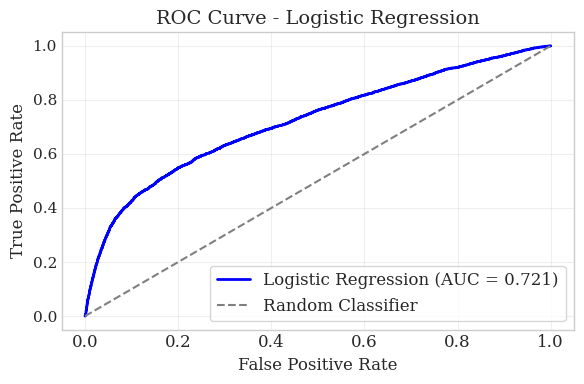

Logistic Regression AUC-ROC: 0.721


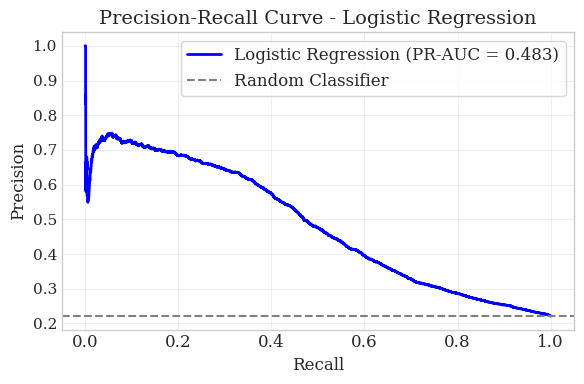

Logistic Regression PR-AUC: 0.483


0.483220738487904

In [ ]:
plot_auc(lr_best_clf, 'Logistic Regression', save= True)
plot_pr_auc(lr_best_clf, 'Logistic Regression',save= True)

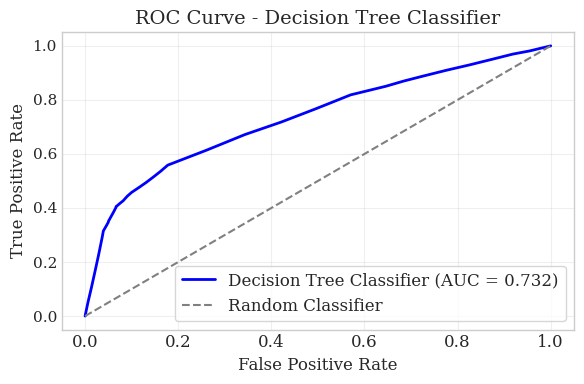

Decision Tree Classifier AUC-ROC: 0.732


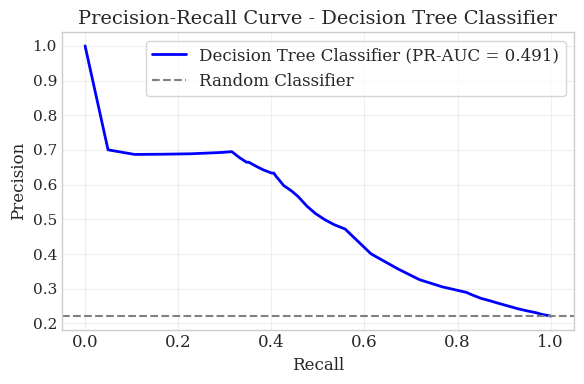

Decision Tree Classifier PR-AUC: 0.491


0.4908891278428607

In [ ]:
plot_auc(tree_best_clf, 'Decision Tree Classifier',save= True)
plot_pr_auc(tree_best_clf, 'Decision Tree Classifier',save= True)

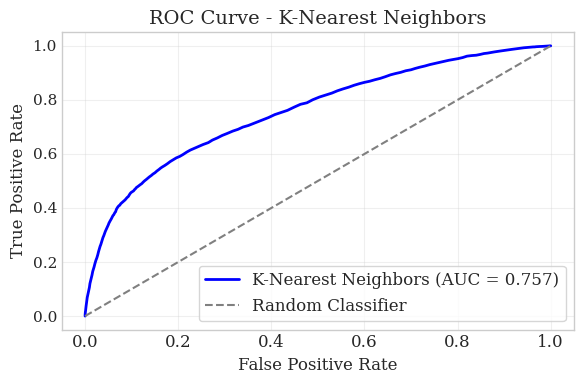

K-Nearest Neighbors AUC-ROC: 0.757


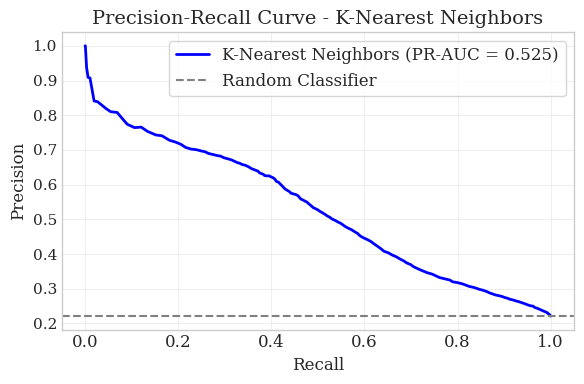

K-Nearest Neighbors PR-AUC: 0.525


0.5248143422863542

In [ ]:
plot_auc(knn_best_clf, 'K-Nearest Neighbors',save= True)
plot_pr_auc(knn_best_clf, 'K-Nearest Neighbors',save= True)

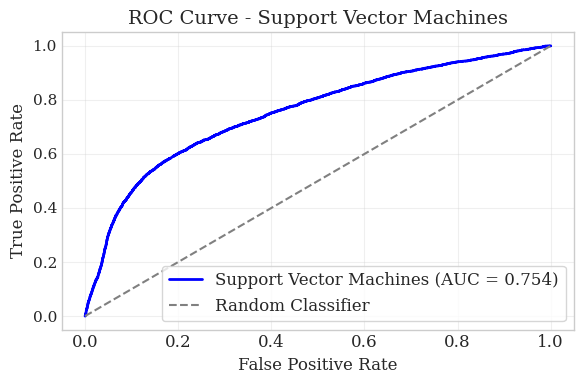

Support Vector Machines AUC-ROC: 0.754


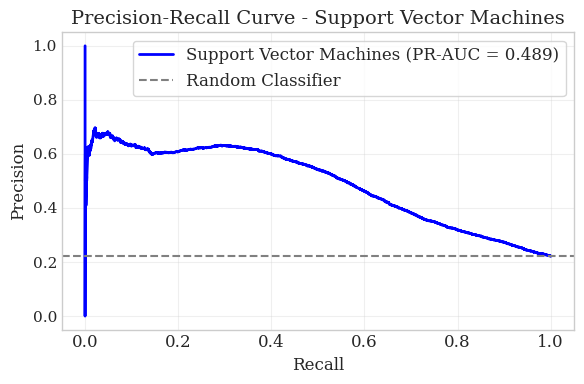

Support Vector Machines PR-AUC: 0.489


0.4887284669909099

In [ ]:
plot_auc(svm_best_clf, 'Support Vector Machines',save= True)
plot_pr_auc(svm_best_clf, 'Support Vector Machines',save= True)

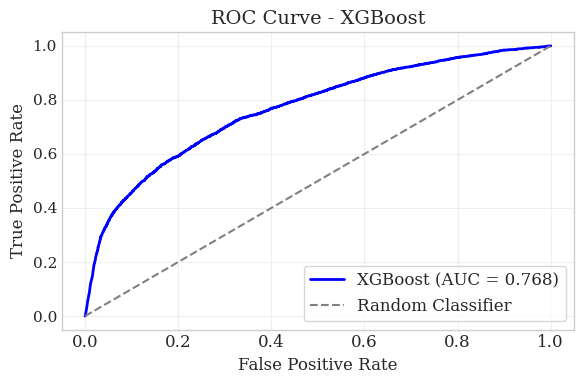

XGBoost AUC-ROC: 0.768


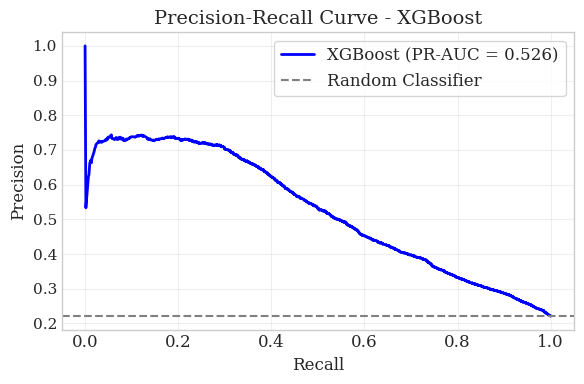

XGBoost PR-AUC: 0.526


0.525862090126936

In [ ]:
plot_auc(xgb_best_clf, 'XGBoost', save=True)
plot_pr_auc(xgb_best_clf, 'XGBoost',save= True)

### 6.2. Indepth Evaluation of top three models on Test set
---

#### 6.2.1. Estimator Reports

#### Rank 1: XGBoost

=============== Performance of XGBoost on Test Set ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.88      0.83      0.85      7001
     Default       0.49      0.60      0.54      1989

    accuracy                           0.78      8990
   macro avg       0.69      0.71      0.70      8990
weighted avg       0.79      0.78      0.78      8990

Recall: 0.59930
Precision-Score: 0.49338
F1-Score: 0.54120


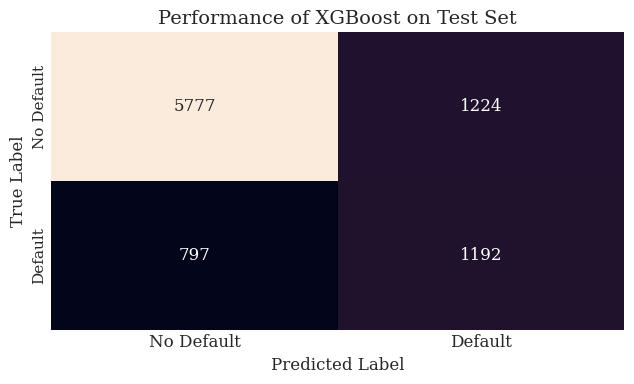

In [ ]:
xgb_pred = xgb_best_clf.predict(X_test)
estimator_report(xgb_pred, 
                y_true= y_test,
                title = 'Performance of XGBoost on Test Set')

#### Rank 2

=============== Performance of SVM on Test Set ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.88      0.84      0.86      7001
     Default       0.52      0.60      0.56      1989

    accuracy                           0.79      8990
   macro avg       0.70      0.72      0.71      8990
weighted avg       0.80      0.79      0.79      8990

Recall: 0.59930
Precision-Score: 0.51804
F1-Score: 0.55571


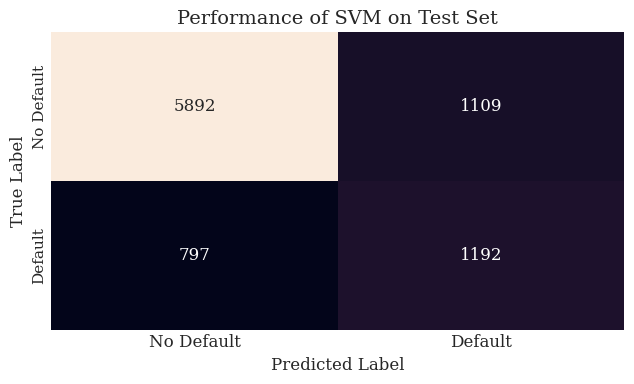

In [ ]:
svm_pred = svm_best_clf.predict(X_test)
estimator_report(svm_pred, 
                 y_true= y_test,
                title = 'Performance of SVM on Test Set' )

#### Rank 3

=============== Performance of KNN on Test Set ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.89      0.77      0.83      7001
     Default       0.45      0.65      0.53      1989

    accuracy                           0.75      8990
   macro avg       0.67      0.71      0.68      8990
weighted avg       0.79      0.75      0.76      8990

Recall: 0.64756
Precision-Score: 0.44956
F1-Score: 0.53070


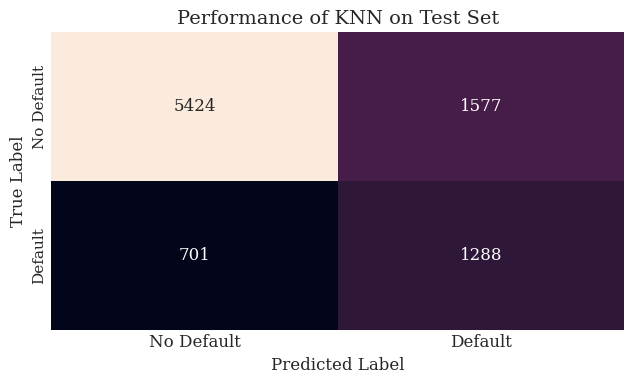

In [ ]:
knn_pred = knn_best_clf.predict(X_test)
estimator_report(knn_pred, y_true= y_test,
                                 title = 'Performance of KNN on Test Set' )

## 7. Did Feature Engineering Help?
---

In [ ]:
# load models. As this has been saved before
xgb_random_search = joblib.load("xgb_random_search.joblib")
svm_random_search = joblib.load("svm_random_search.joblib") # training time is quite long
lr_random_search = joblib.load("lr_random_search.joblib")
tree_random_search = joblib.load("tree_random_search.joblib")
knn_random_search = joblib.load("knn_random_search.joblib")

# get finetuned parameters for models 
xgb_tuned_param = xgb_random_search[0].named_steps['xgb'].get_params()
svm_tuned_param = svm_random_search[0].named_steps['svm'].get_params()
lr_tuned_param = lr_random_search[0].named_steps['lr'].get_params()
tree_tuned_param = tree_random_search[0].named_steps['tree'].get_params()
knn_tuned_param = knn_random_search[0].named_steps['knn'].get_params()


In [ ]:
def check_engineering(clf, tuned_params, title, X_raw=X_train_raw, y_raw=y_train_raw, X_transf=X_train,y_transf=y_train):
    """
    clf: sklearn_classifier
    tuned_params: fined tuned params
    X_raw
    y_raw
    X_transf
    y_transf
    """
    tuned = clf(**tuned_params) # remeber that ** unpacks a dictionary
    transformed_pred =  cross_val_predict(estimator=tuned,
                                  X=X_transf,
                                  y=y_transf,cv=cv)

    raw_pred =  cross_val_predict(estimator=tuned,
                                  X=X_raw,
                                  y=y_raw,cv=cv)

    print('='*50)
    print(f"FOR DATA WITH NO-TRANSFORMATION {title}")
    print(classification_report(y_raw, raw_pred))
    print()
    print('='*50)
    print(f"FOR DATA WITH TRANSFORMATION {title}")
    print(classification_report(y_transf, transformed_pred))

In [ ]:
check_engineering(XGBClassifier,xgb_tuned_param, 'XGBClassifier')

FOR DATA WITH NO-TRANSFORMATION XGBClassifier
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     16334
           1       0.71      0.30      0.42      4641

    accuracy                           0.82     20975
   macro avg       0.77      0.63      0.66     20975
weighted avg       0.80      0.82      0.79     20975


FOR DATA WITH TRANSFORMATION XGBClassifier
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     16334
           1       0.71      0.30      0.42      4641

    accuracy                           0.82     20975
   macro avg       0.77      0.63      0.66     20975
weighted avg       0.80      0.82      0.79     20975



In [ ]:
check_engineering(LogisticRegression, lr_tuned_param,'LogisticRegression')

FOR DATA WITH NO-TRANSFORMATION LogisticRegression
              precision    recall  f1-score   support

           0       0.87      0.70      0.78     16334
           1       0.38      0.64      0.47      4641

    accuracy                           0.69     20975
   macro avg       0.62      0.67      0.63     20975
weighted avg       0.76      0.69      0.71     20975


FOR DATA WITH TRANSFORMATION LogisticRegression
              precision    recall  f1-score   support

           0       0.87      0.69      0.77     16334
           1       0.38      0.65      0.48      4641

    accuracy                           0.68     20975
   macro avg       0.62      0.67      0.62     20975
weighted avg       0.76      0.68      0.71     20975



In [ ]:
check_engineering(DecisionTreeClassifier, tree_tuned_param, 'DecisionTreeClassifier')

FOR DATA WITH NO-TRANSFORMATION DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     16334
           1       0.64      0.27      0.38      4641

    accuracy                           0.80     20975
   macro avg       0.73      0.61      0.63     20975
weighted avg       0.78      0.80      0.77     20975


FOR DATA WITH TRANSFORMATION DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16334
           1       0.70      0.32      0.44      4641

    accuracy                           0.82     20975
   macro avg       0.77      0.64      0.66     20975
weighted avg       0.80      0.82      0.79     20975



In [ ]:
check_engineering(KNeighborsClassifier, knn_tuned_param,"KNeighborsClassifier")

FOR DATA WITH NO-TRANSFORMATION KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     16334
           1       0.67      0.26      0.38      4641

    accuracy                           0.81     20975
   macro avg       0.75      0.61      0.63     20975
weighted avg       0.79      0.81      0.77     20975


FOR DATA WITH TRANSFORMATION KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     16334
           1       0.66      0.33      0.44      4641

    accuracy                           0.81     20975
   macro avg       0.75      0.64      0.66     20975
weighted avg       0.80      0.81      0.79     20975



In [ ]:
check_engineering(SVC, svm_tuned_param, "Support Vector Classifier")

FOR DATA WITH NO-TRANSFORMATION Support Vector Classifier
              precision    recall  f1-score   support

           0       0.87      0.82      0.85     16334
           1       0.48      0.58      0.53      4641

    accuracy                           0.77     20975
   macro avg       0.68      0.70      0.69     20975
weighted avg       0.79      0.77      0.78     20975


FOR DATA WITH TRANSFORMATION Support Vector Classifier
              precision    recall  f1-score   support

           0       0.87      0.84      0.86     16334
           1       0.50      0.55      0.52      4641

    accuracy                           0.78     20975
   macro avg       0.68      0.70      0.69     20975
weighted avg       0.79      0.78      0.78     20975



#### Appendix

In [ ]:
# save models and pipelines
joblib.dump(svm_random_search,"svm_random_search.joblib") # training time is quite long
joblib.dump(lr_random_search,"lr_random_search.joblib")
joblib.dump(tree_random_search,"tree_random_search.joblib")
joblib.dump(knn_random_search,"knn_random_search.joblib")
joblib.dump(xgb_random_search,"xgb_random_search.joblib")

['knn_random_search.joblib']

=============== Logisitic Regression Performance on Test Set ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.88      0.69      0.77      7001
     Default       0.37      0.66      0.48      1989

    accuracy                           0.68      8990
   macro avg       0.63      0.67      0.62      8990
weighted avg       0.77      0.68      0.71      8990

Recall: 0.65762
Precision-Score: 0.37468
F1-Score: 0.47737


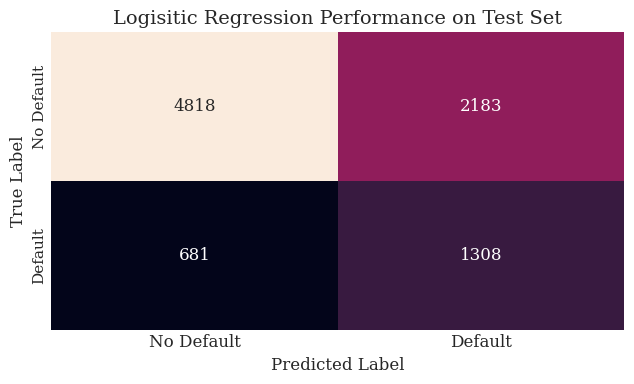

In [ ]:
lr_pred = lr_best_clf.predict(X_test)
estimator_report(lr_pred, y_true= y_test,
                 title = 'Logisitic Regression Performance on Test Set')

=============== Performance of Decision Tree on Test Set ==========
==================== Classification Report ====================
              precision    recall  f1-score   support

 Non-Default       0.88      0.82      0.85      7001
     Default       0.48      0.60      0.53      1989

    accuracy                           0.77      8990
   macro avg       0.68      0.71      0.69      8990
weighted avg       0.79      0.77      0.78      8990

Recall: 0.59628
Precision-Score: 0.47977
F1-Score: 0.53172


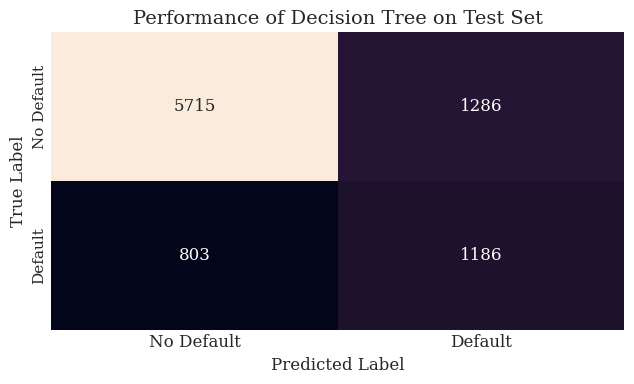

In [ ]:
tree_pred = tree_best_clf.predict(X_test)
estimator_report(tree_pred, 
                y_true= y_test,
                title = 'Performance of Decision Tree on Test Set' )

In [ ]:
# let's check training and tuning time
def training_tuning_time(search_object):
    """
    Gets training and tuning time from tuple containing saved randomsearch objects and 
    other metrics.

    Parameters
    ----------
        search_object : tuple
            Tuple containing random_search objects which was defined using or function tune params.
    
    Returns
    -------
        tuple:
            A tuple containing
                - Tuning time of RandomisedSearchCV
                - Training time of RandomisedSearchCV
    """
    train_time = search_object[1]
    tune_time = search_object[2]
    return {"Tuning Time (s)":train_time,
            "Training time (s)": tune_time}


In [ ]:
rand_search_obj = [tree_random_search,
                   lr_random_search,
                   xgb_random_search,
                   knn_random_search,
                   svm_random_search]

In [ ]:
names = [
    'Decision Tree',
    'Logistic Regression',
    'XGBoost',
    'K-Nearest Neighbors',
    'Support Vector Machines'
    ]

In [ ]:
time = []
for object in rand_search_obj:
    time.append(training_tuning_time(object))


In [ ]:
training_tuning_time(tree_random_search)

{'Tuning Time (s)': 30.91098976135254, 'Training time (s)': 0.2761654853820801}

In [ ]:
time_df = pd.DataFrame(time, index= names)
time_df.index.name = 'Models'

In [ ]:
time_df

Tuning Time (s)  Training time (s)
Models                                                     
Decision Tree                  30.910990           0.276165
Logistic Regression            26.154769           0.443446
XGBoost                        51.626418           0.573935
K-Nearest Neighbors           481.812789           0.205669
Support Vector Machines      9167.375374         514.231925

In [ ]:
#time_df.to_csv(r"C:\Users\banji\Downloads\model_runtime.csv")

In [ ]:
'''
# load
svm_random_search = joblib.load("svm_random_search.joblib") # training time is quite long
lr_random_search = joblib.load("lr_random_search.joblib")
tree_random_search= joblib.load("tree_random_search.joblib")
knn_random_search = joblib.load("knn_random_search.joblib")
xgb_random_search = joblib.load("xgb_random_search.joblib")

# tuned clf
svm_best_clf = svm_random_search[0]
lr_best_clf=lr_random_search[0]
tree_best_clf=tree_random_search[0]
knn_best_clf=knn_random_search[0] 
xgb_best_clf=xgb_random_search[0] 

'''
pass